In [1]:
guppy_path = '../../OFT_pharmacology_guppy'
raw_path = '../../OFT_pharmacology'

In [2]:
guppy_path = '/Users/fsp585/Desktop/GetherLabCode/Openfield/GqCoh1And2_OFT/First Test Round_guppy'
raw_path = '/Users/fsp585/Desktop/GetherLabCode/Openfield/GqCoh1And2_OFT/First Test Round'

In [3]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats

In [5]:
from processing.tracking_based_segmentation import *
from processing.segment_dfs import create_segment_dfs
from data.guppy_loading import create_all_z_score_dfs

In [6]:
all_z_score_dfs = create_all_z_score_dfs(guppy_path)

In [7]:
all_z_score_dfs

{('145',
  'mPFC'):             data   timestamps
 14818   1.748048  1592.342144
 14819   1.735837  1592.392160
 14820   1.725500  1592.442144
 14821   1.718862  1592.492160
 14822   1.713262  1592.542144
 ...          ...          ...
 146396  1.141569  8171.389888
 146397  1.133584  8171.439904
 146398  1.127278  8171.489888
 146399  1.128783  8171.539904
 146400  1.136973  8171.589888
 
 [131583 rows x 2 columns],
 ('143',
  'LH'):             data   timestamps
 9932    1.179639  1348.061792
 9933    1.209994  1348.111776
 9934    1.252971  1348.161792
 9935    1.276494  1348.211776
 9936    1.300159  1348.261792
 ...          ...          ...
 146396 -0.525989  8171.414912
 146397 -0.540431  8171.464896
 146398 -0.562099  8171.514880
 146399 -0.599404  8171.564896
 146400 -0.657293  8171.614880
 
 [136469 rows x 2 columns],
 ('145',
  'LH'):             data   timestamps
 15865   0.658958  1644.693376
 15866   0.592949  1644.743360
 15867   0.486675  1644.793376
 15868   0.372158  

In [8]:
# if we do tracking based segmentation
all_mouse_intervals_timestamps = process_mouse_data_from_path(raw_path)
all_mouse_segments = {k: nan_interval_to_segments(v) for k, v in all_mouse_intervals_timestamps.items()}

StopIteration: 

In [9]:
all_mouse_segments['697']

NameError: name 'all_mouse_segments' is not defined

In [9]:
segment_names = ['baseline', 'nicotine', 'antagonist']
all_segment_dfs = create_segment_dfs(segment_names, all_z_score_dfs, all_mouse_segments)

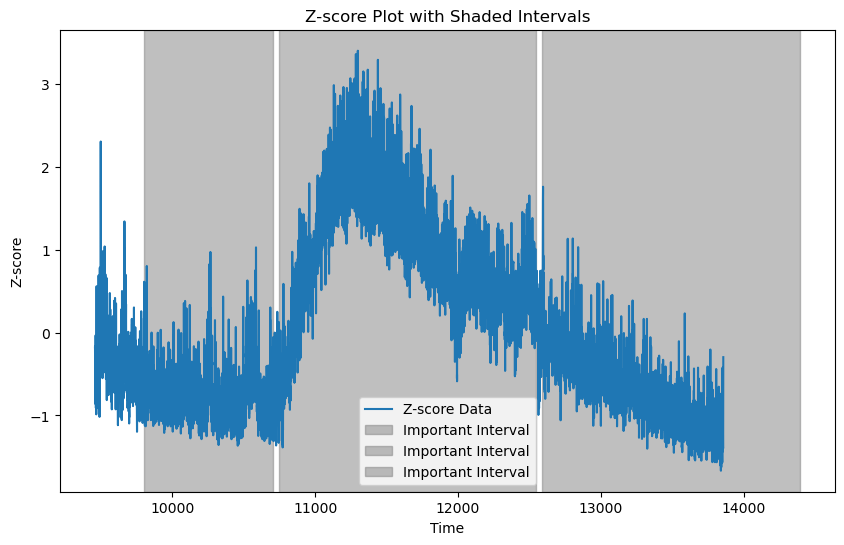

In [10]:
# Assuming you have your plotting data and intervals as specified
timestamps = all_z_score_dfs['697', 'vs']['timestamps']
data = all_z_score_dfs['697', 'vs']['data']
intervals = all_mouse_segments['697']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(timestamps, data, label='Z-score Data')

# Loop through the intervals and add each as a shaded region
for start, end in intervals:
    plt.axvspan(start, end, color='grey', alpha=0.5, label='Important Interval')

# Add labels, title, legend, etc.
plt.xlabel('Time')
plt.ylabel('Z-score')
plt.title('Z-score Plot with Shaded Intervals')
plt.legend()

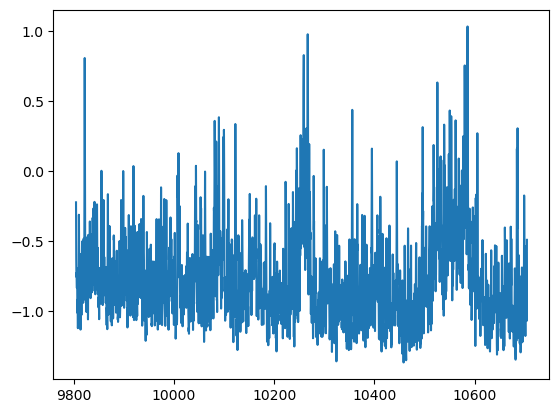

In [11]:
plt.plot(all_segment_dfs['baseline'][('697', 'vs')]['timestamps'],
         all_segment_dfs['baseline'][('697', 'vs')]['data'])

### Entire signal plot

### Frequency split plot

In [10]:
def process_signal(signal, sampling_rate, middle_freq):
    # Perform FFT
    fft_signal = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1 / sampling_rate)

    # Create a mask for low frequencies (0 to middle_freq)
    low_freq_mask = np.abs(frequencies) <= middle_freq

    # Create low-frequency component by masking
    low_freq_fft = fft_signal * low_freq_mask
    low_freq_component = np.fft.ifft(low_freq_fft)

    # Create high-frequency component by masking
    high_freq_mask = np.abs(frequencies) > middle_freq
    high_freq_fft = fft_signal * high_freq_mask
    high_freq_component = np.fft.ifft(high_freq_fft)

    return signal, frequencies, low_freq_component, high_freq_component

In [22]:
def plot_signal(t, signal, low_freq_component, high_freq_component, middle_freq, suptitle, brain_region, save=False):
    # Calculate global min and max
    # brain_reg_to_color = {'vs': 'purple',
    #                   'dms': 'forestgreen',
    #                   'dls': 'C0'}

    brain_reg_to_color = {'mPFC': 'blue',
                          'LH': 'orange'}
    color = brain_reg_to_color[brain_region]

    all_signals = [signal, low_freq_component.real, high_freq_component.real, 
                   low_freq_component.real + high_freq_component.real]
    global_min = min(np.min(sig) for sig in all_signals)
    global_max = max(np.max(sig) for sig in all_signals)

    # Plotting the results
    fig, axs = plt.subplots(3, 1, figsize=(6, 6))
    fig.suptitle(suptitle, fontsize=16)

    plot_data = [
        (signal, 'Original Signal'),
        (low_freq_component.real, f'Low-Frequency Component (0 to {middle_freq} Hz)'),
        (high_freq_component.real, f'High-Frequency Component ({middle_freq} to Nyquist)')
    ]

    for i, (data, title) in enumerate(plot_data):
        axs[i].plot(t, data, color=color)
        axs[i].set_title(title)
        axs[i].set_ylim(global_min, global_max)
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Amplitude')

    plt.tight_layout()
    if save:
        plt.savefig(save)
    else:
        plt.show()

### histogram of frequency densities

In [23]:
def compute_frequency_density(signal, sampling_rate):
    # Perform FFT
    fft_signal = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1 / sampling_rate)

    # Compute the magnitude of the FFT
    magnitude = np.abs(fft_signal)

    # Normalize the magnitudes to get the relative density
    relative_density = magnitude / np.sum(magnitude)

    return frequencies, relative_density

In [24]:
def compute_frequency_amplitude(signal, sampling_rate):
    """
    Compute the amplitude of the frequency components of a signal using the Fast Fourier Transform (FFT).

    Args:
        signal (array): The input signal from which to compute the frequency amplitude.
        sampling_rate (float): The sampling rate of the signal in Hz.

    Returns:
        tuple: A tuple containing:
            - frequencies (array): An array of the frequencies corresponding to the FFT components.
            - amplitude (array): An array of the amplitude of the FFT components.
    """
    # Perform FFT
    fft_signal = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1 / sampling_rate)

    # Compute the magnitude of the FFT
    amplitude = np.abs(fft_signal)

    return frequencies, amplitude

In [25]:
def plot_frequency_density(positive_frequencies_list, positive_relative_density_list, a, b, num_bins):
    # Logarithmic binning within the specified range using log2
    log_bins = np.logspace(np.log2(a), np.log2(b), num_bins, base=2)
    
    # Initialize arrays to store binned data
    binned_densities = np.zeros((len(positive_frequencies_list), num_bins-1))
    
    # Bin each dataset individually
    for i, (freqs, densities) in enumerate(zip(positive_frequencies_list, positive_relative_density_list)):
        binned_densities[i], _ = np.histogram(freqs, bins=log_bins, weights=densities)
    
    # Calculate mean and SEM of binned densities
    mean_densities = np.mean(binned_densities, axis=0)
    sem_densities = stats.sem(binned_densities, axis=0)
    
    # Plotting
    plt.figure(figsize=(8, 4))
    
    # Plot histogram
    bin_centers = 0.5 * (log_bins[1:] + log_bins[:-1])
    plt.bar(bin_centers, mean_densities, width=np.diff(log_bins), 
            align='center', alpha=0.7, label='Mean Density')
    
    # Add error bars using SEM
    plt.errorbar(bin_centers, mean_densities, yerr=sem_densities, fmt='none', 
                 ecolor='red', elinewidth=1, capsize=2, alpha=0.5, 
                 label='Standard Error of Mean')

    plt.xscale('log', base=2)
    plt.xlim(a, b)
    
    # Format the x-axis tick labels with specified number of decimals
    def log2_tick_formatter(x, pos):
        return f'{{:.{5}f}}'.format(x)
    
    formatter = ticker.FuncFormatter(log2_tick_formatter)
    plt.gca().xaxis.set_major_formatter(formatter)
    
    # Set x-axis ticks to be powers of 2
    tick_locations = [2**i for i in range(int(np.log2(a)), int(np.log2(b))+1)]
    plt.xticks(tick_locations, rotation=45)

    plt.title('Mean Relative Density of Different Frequencies in the Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Relative Density')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [26]:
def plot_combined_frequency_density(freq_lists, density_lists, a, b, num_bins, labels, colors, title, fname=None):
    plt.figure(figsize=(8, 4))
    
    log_bins = np.logspace(np.log2(a), np.log2(b), num_bins, base=2)
    bin_centers = 0.5 * (log_bins[1:] + log_bins[:-1])
    
    n_datasets = len(freq_lists)
    width = np.diff(log_bins) / (n_datasets + 1)  # +1 to leave some space between groups
    
    for i, (freqs_list, densities_list, label, color) in enumerate(zip(freq_lists, density_lists, labels, colors)):
        # Initialize arrays to store binned data
        binned_densities = np.zeros((len(freqs_list), num_bins-1))
        
        # Bin each dataset individually
        for j, (freqs, densities) in enumerate(zip(freqs_list, densities_list)):
            binned_densities[j], _ = np.histogram(freqs, bins=log_bins, weights=densities)
        
        # Calculate mean and SEM of binned densities
        mean_densities = np.mean(binned_densities, axis=0)
        sem_densities = stats.sem(binned_densities, axis=0)
        
        # Calculate offset for this dataset
        offset = (i - (n_datasets-1)/2) * width
        
        # Plot histogram with offset
        plt.bar(bin_centers + offset, mean_densities, width=width, 
                align='center', alpha=0.7, color=color, label=f'{label}')
        
        # Add error bars using SEM
        plt.errorbar(bin_centers + offset, mean_densities, yerr=sem_densities, fmt='none', 
                     ecolor='black', elinewidth=1, capsize=2, alpha=0.5)

    plt.xscale('log', base=2)
    plt.xlim(a, b)
    
    # Format the x-axis tick labels with specified number of decimals
    def log2_tick_formatter(x, pos):
        return f'{x:.5f}'
    
    formatter = ticker.FuncFormatter(log2_tick_formatter)
    plt.gca().xaxis.set_major_formatter(formatter)
    
    # Set x-axis ticks to be powers of 2
    tick_locations = [2**i for i in range(int(np.log2(a)), int(np.log2(b))+1)]
    plt.xticks(tick_locations, rotation=45, fontsize=14)
    plt.yticks(fontsize=14)

    plt.title(title, fontsize=24)
    plt.xlabel('Frequency (Hz)', fontsize=16)
    plt.ylabel('Relative Density', fontsize=16)
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend(fontsize=16)

    plt.tight_layout()
    if fname is not None:
        plt.savefig(fname)
    else:
        plt.show()

In [27]:
def plot_combined_frequency_amplitude(freq_lists, amplitude_lists, a, b, num_bins, labels, colors, title, fname=None):
    plt.figure(figsize=(8, 4))
    
    log_bins = np.logspace(np.log2(a), np.log2(b), num_bins, base=2)
    bin_centers = 0.5 * (log_bins[1:] + log_bins[:-1])
    
    n_datasets = len(freq_lists)
    width = np.diff(log_bins) / (n_datasets + 1)  # +1 to leave some space between groups
    
    for i, (freqs_list, amplitudes_list, label, color) in enumerate(zip(freq_lists, amplitude_lists, labels, colors)):
        # Initialize arrays to store binned data
        binned_amplitudes = np.zeros((len(freqs_list), num_bins-1))
        
        # Bin each dataset individually
        for j, (freqs, amplitudes) in enumerate(zip(freqs_list, amplitudes_list)):
            binned_amplitudes[j], _ = np.histogram(freqs, bins=log_bins, weights=amplitudes)
        
        # Calculate mean and SEM of binned amplitudes
        mean_amplitudes = np.mean(binned_amplitudes, axis=0)
        sem_amplitudes = stats.sem(binned_amplitudes, axis=0)
        
        # Calculate offset for this dataset
        offset = (i - (n_datasets-1)/2) * width
        
        # Plot histogram with offset
        plt.bar(bin_centers + offset, mean_amplitudes, width=width, 
                align='center', alpha=0.7, color=color, label=f'{label} (Mean Amplitude)')
        
        # Add error bars using SEM
        plt.errorbar(bin_centers + offset, mean_amplitudes, yerr=sem_amplitudes, fmt='none', 
                     ecolor='black', elinewidth=1, capsize=2, alpha=0.5)

    plt.xscale('log', base=2)
    plt.xlim(a, b)
    
    # Format the x-axis tick labels with specified number of decimals
    def log2_tick_formatter(x, pos):
        return f'{x:.2f}'
    
    formatter = ticker.FuncFormatter(log2_tick_formatter)
    plt.gca().xaxis.set_major_formatter(formatter)
    
    # Set x-axis ticks to be powers of 2
    tick_locations = [2**i for i in range(int(np.log2(a)), int(np.log2(b))+1)]
    plt.xticks(tick_locations, rotation=45, fontsize=14)
    plt.yticks(fontsize=14)

    plt.title(title, fontsize=24)
    plt.xlabel('Frequency (Hz)', fontsize=16)
    plt.ylabel('Amplitude', fontsize=16)
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.legend(fontsize=16)

    plt.tight_layout()
    if fname is not None:
        plt.savefig(fname)
    else:
        plt.show()

### Usage

In [28]:
sampling_rate = 20  # samples per second
duration = 10  # seconds
middle_freq = 0.01  # cutoff frequency
a = 1/30/60  # Minimum frequency for x-axis
b = 10  # Maximum frequency for x-axis
num_bins = 30  # Number of bins for frequency aggregation

In [29]:
all_z_score_dfs

{('145',
  'mPFC'):             data   timestamps
 14818   1.748048  1592.342144
 14819   1.735837  1592.392160
 14820   1.725500  1592.442144
 14821   1.718862  1592.492160
 14822   1.713262  1592.542144
 ...          ...          ...
 146396  1.141569  8171.389888
 146397  1.133584  8171.439904
 146398  1.127278  8171.489888
 146399  1.128783  8171.539904
 146400  1.136973  8171.589888
 
 [131583 rows x 2 columns],
 ('143',
  'LH'):             data   timestamps
 9932    1.179639  1348.061792
 9933    1.209994  1348.111776
 9934    1.252971  1348.161792
 9935    1.276494  1348.211776
 9936    1.300159  1348.261792
 ...          ...          ...
 146396 -0.525989  8171.414912
 146397 -0.540431  8171.464896
 146398 -0.562099  8171.514880
 146399 -0.599404  8171.564896
 146400 -0.657293  8171.614880
 
 [136469 rows x 2 columns],
 ('145',
  'LH'):             data   timestamps
 15865   0.658958  1644.693376
 15866   0.592949  1644.743360
 15867   0.486675  1644.793376
 15868   0.372158  

In [30]:
all_z_score_dfs.keys()

dict_keys([('145', 'mPFC'), ('143', 'LH'), ('145', 'LH'), ('143', 'mPFC'), ('157', 'LH'), ('147', 'LH'), ('147', 'mPFC'), ('157', 'mPFC'), ('159', 'mPFC'), ('161', 'LH'), ('161', 'mPFC'), ('159', 'LH'), ('171', 'mPFC'), ('173', 'LH'), ('171', 'LH'), ('173', 'mPFC'), ('69', 'LH'), ('69', 'mPFC'), ('71', 'LH'), ('71', 'mPFC'), ('75', 'LH'), ('75', 'mPFC'), ('73', 'mPFC'), ('73', 'LH'), ('77', 'LH'), ('79', 'LH'), ('79', 'mPFC'), ('77', 'mPFC'), ('81', 'mPFC'), ('83', 'LH'), ('83', 'mPFC'), ('81', 'LH'), ('87', 'mPFC'), ('85', 'LH'), ('87', 'LH'), ('85', 'mPFC'), ('125', 'mPFC'), ('127', 'mPFC'), ('127', 'LH'), ('125', 'LH'), ('129', 'mPFC'), ('131', 'mPFC'), ('131', 'LH'), ('129', 'LH'), ('135', 'mPFC'), ('137', 'mPFC'), ('135', 'LH'), ('137', 'LH'), ('133', 'mPFC'), ('139', 'mPFC'), ('133', 'LH'), ('139', 'LH')])

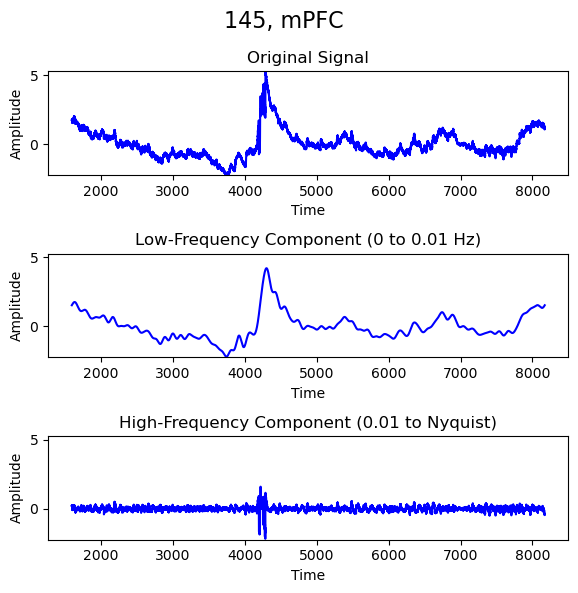

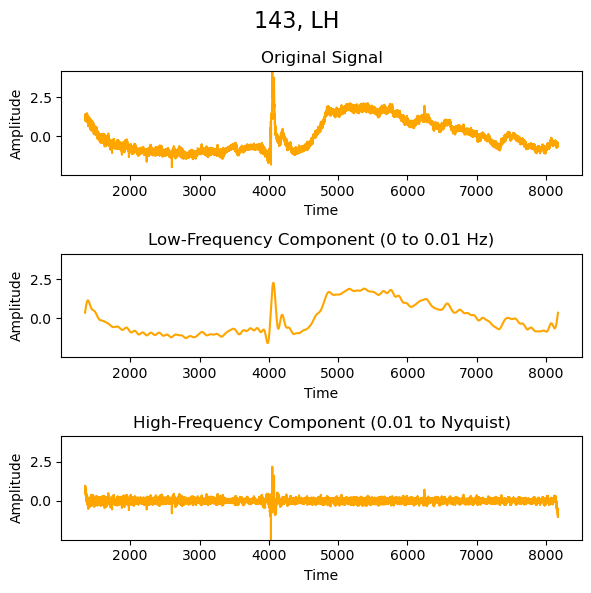

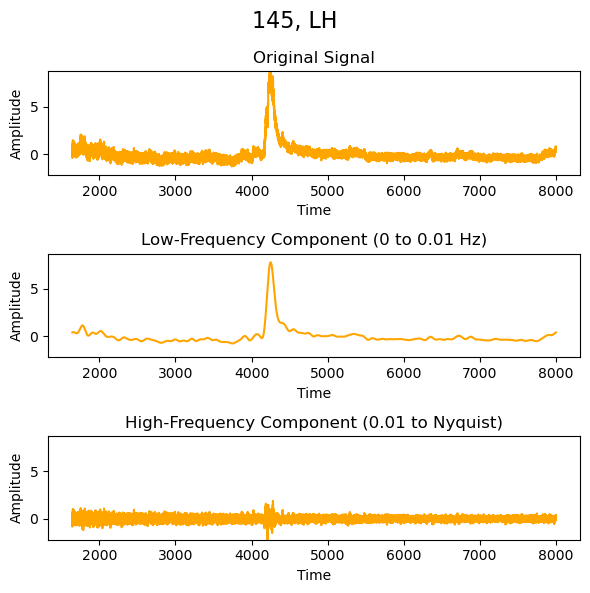

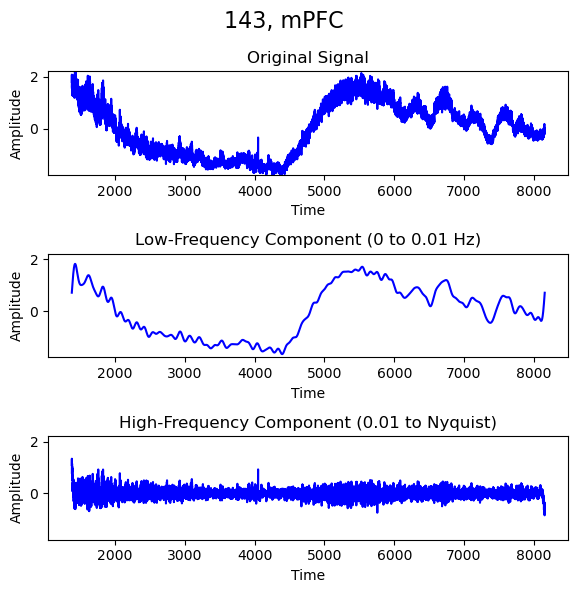

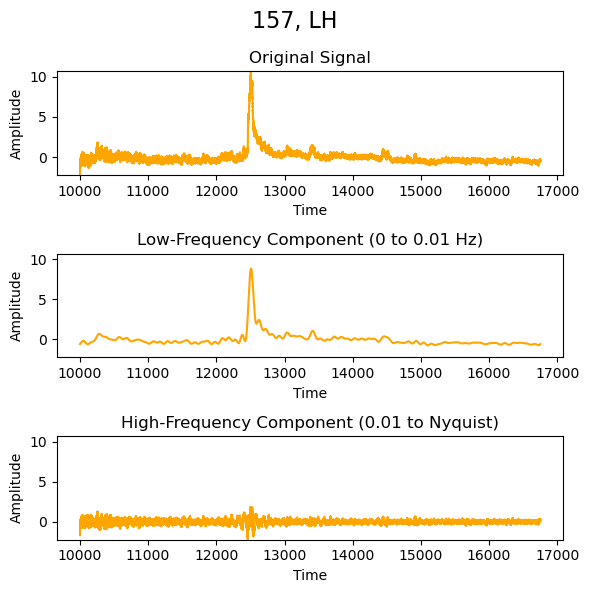

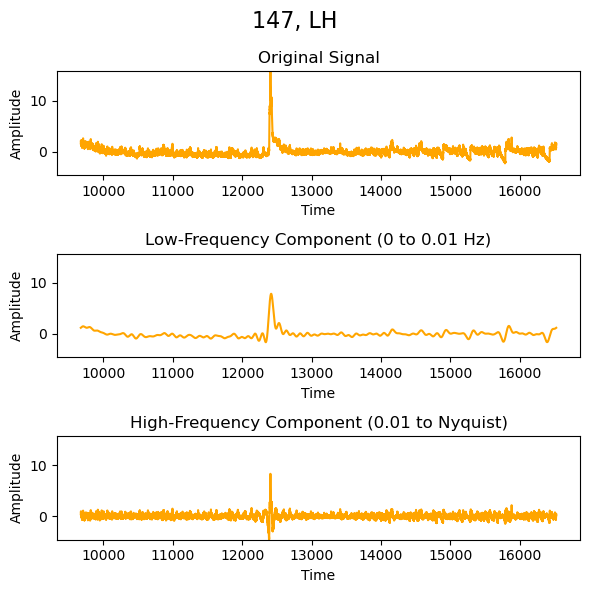

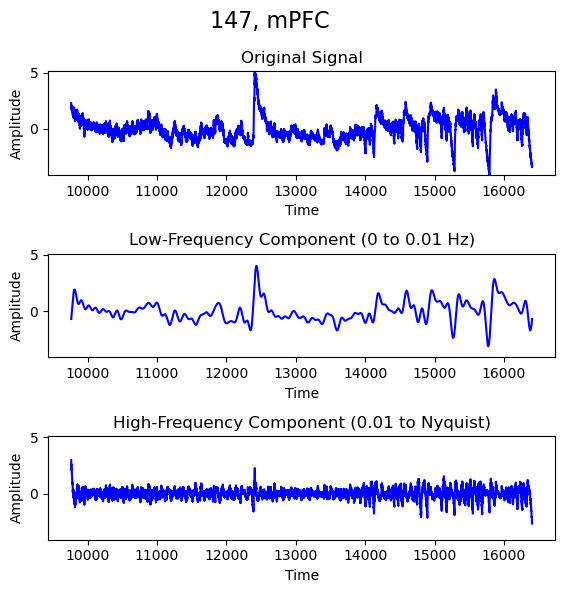

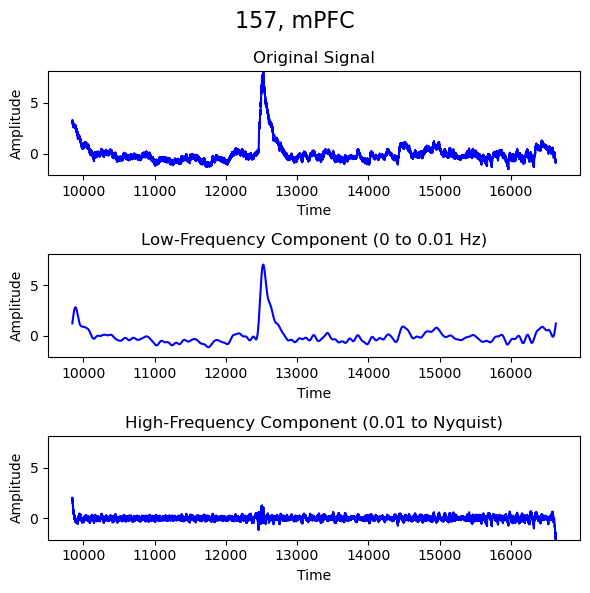

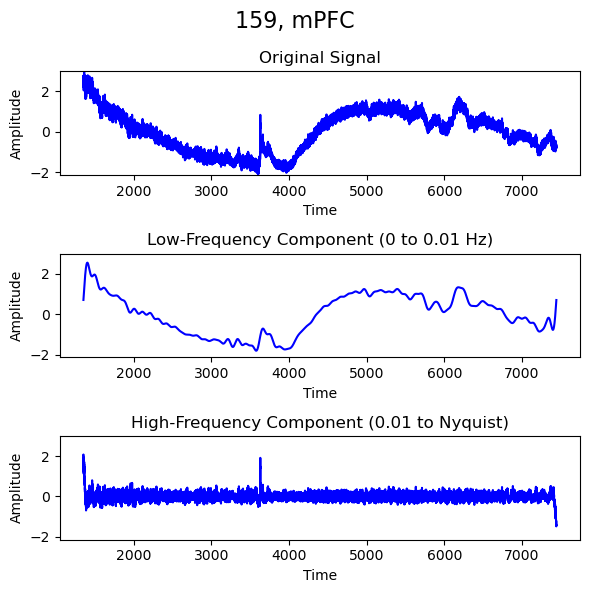

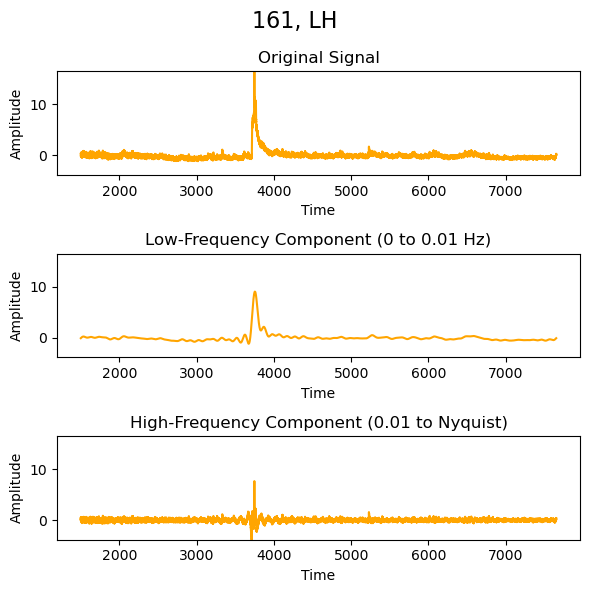

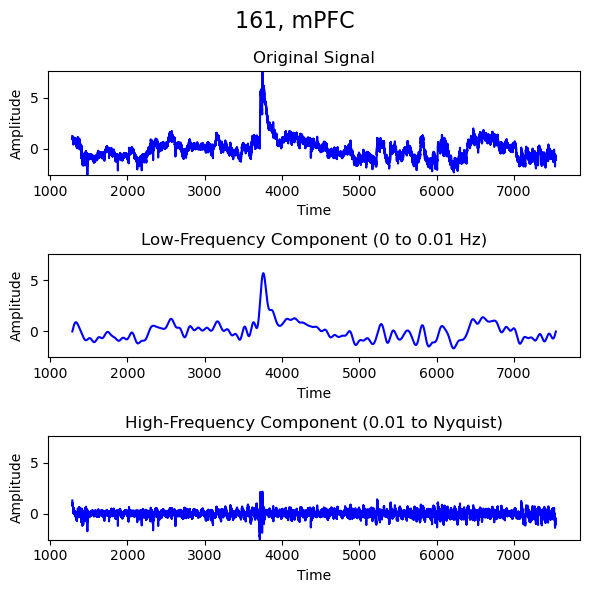

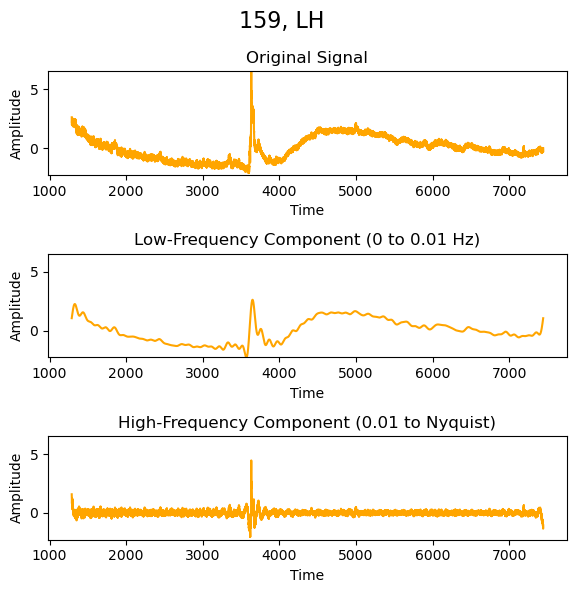

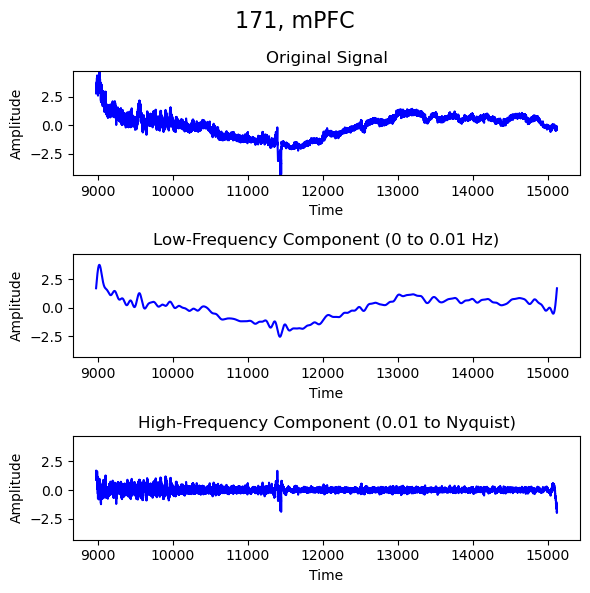

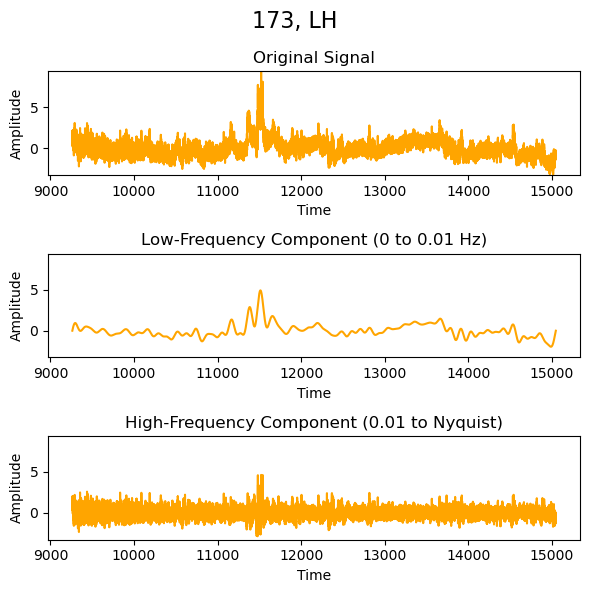

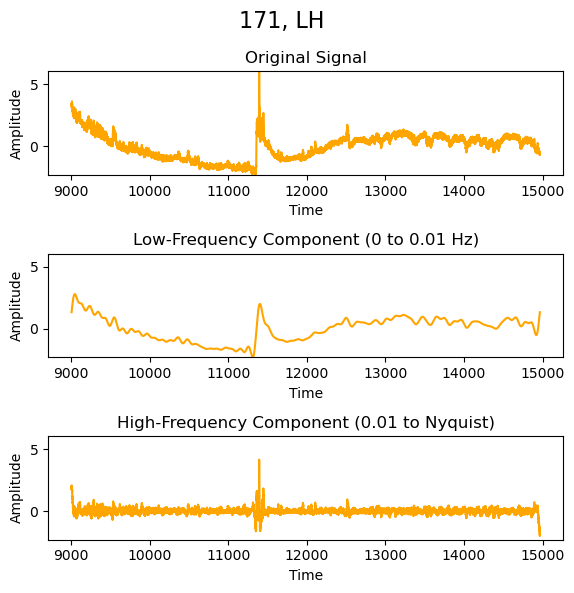

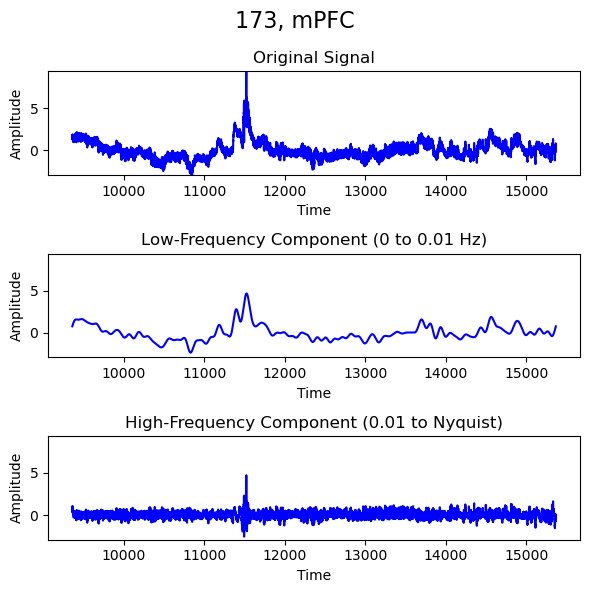

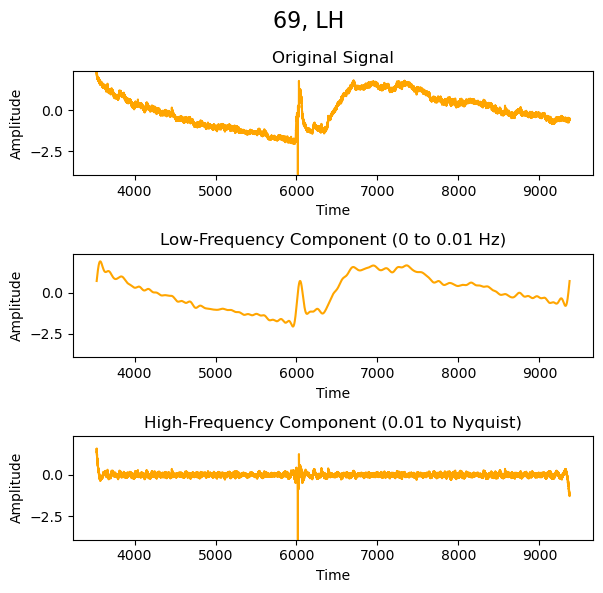

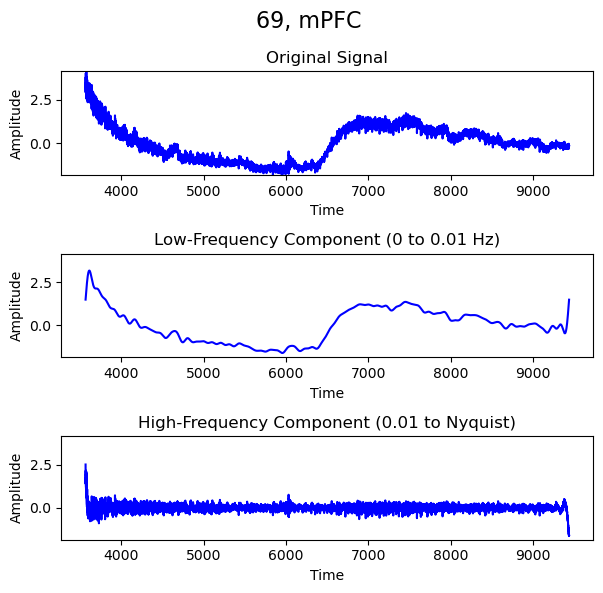

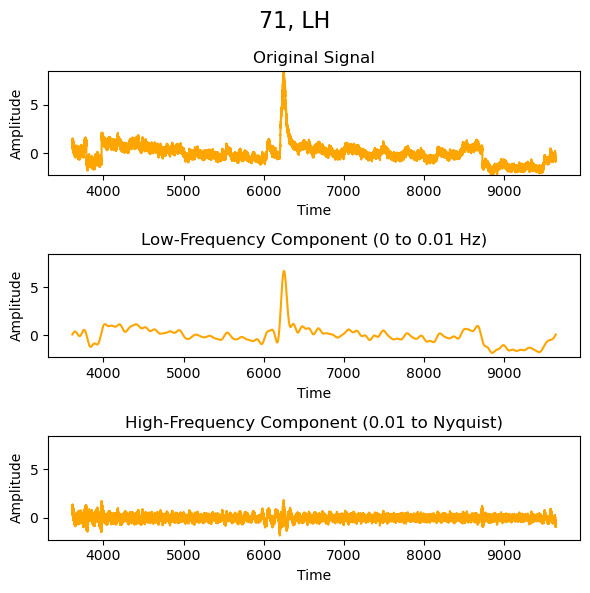

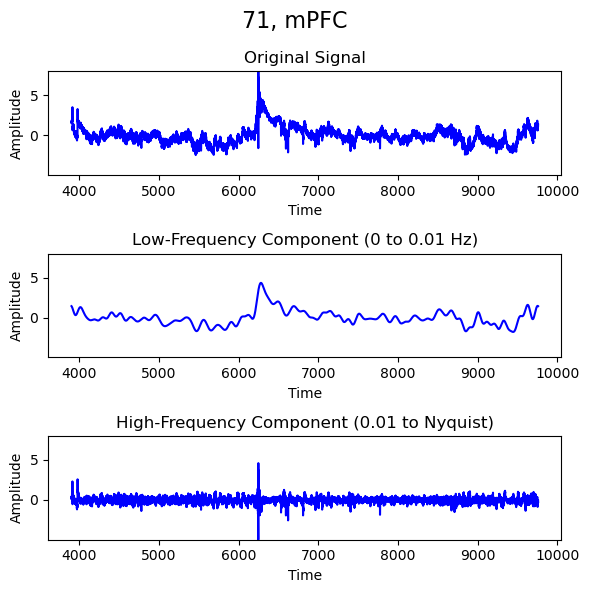

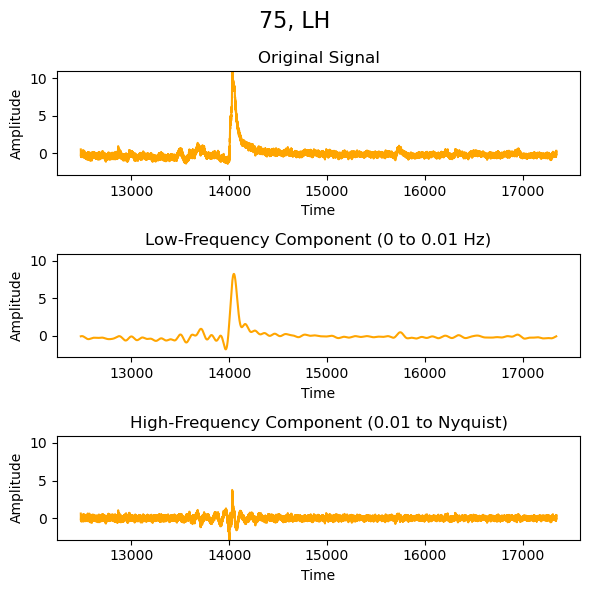

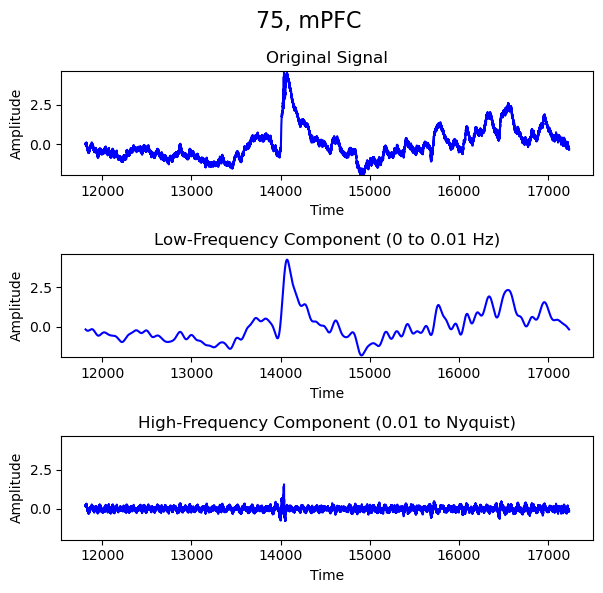

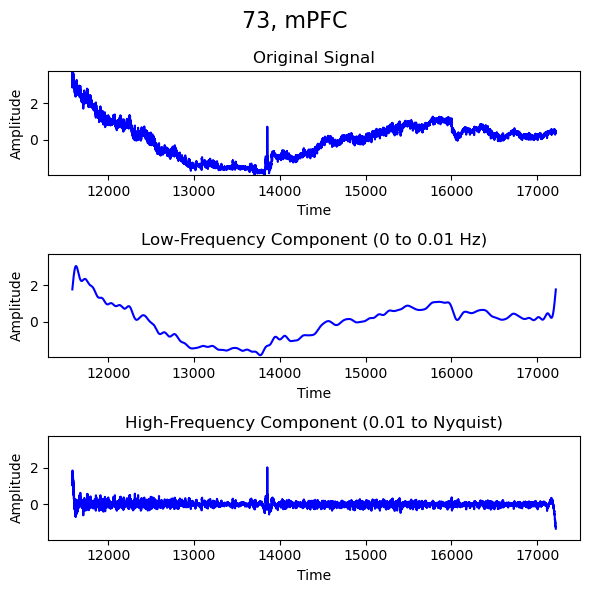

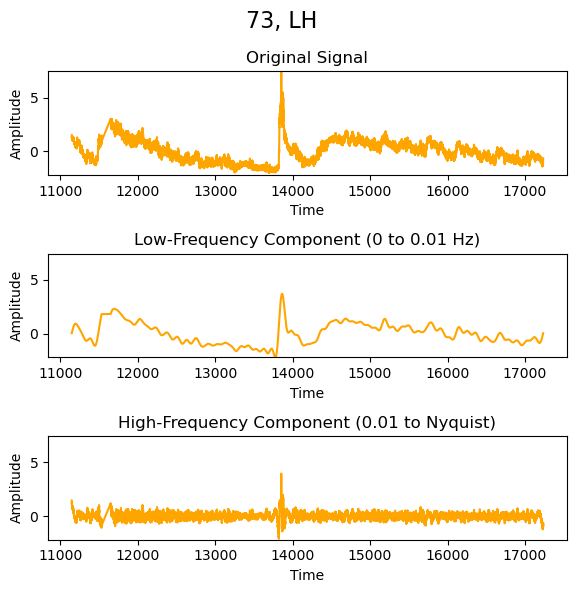

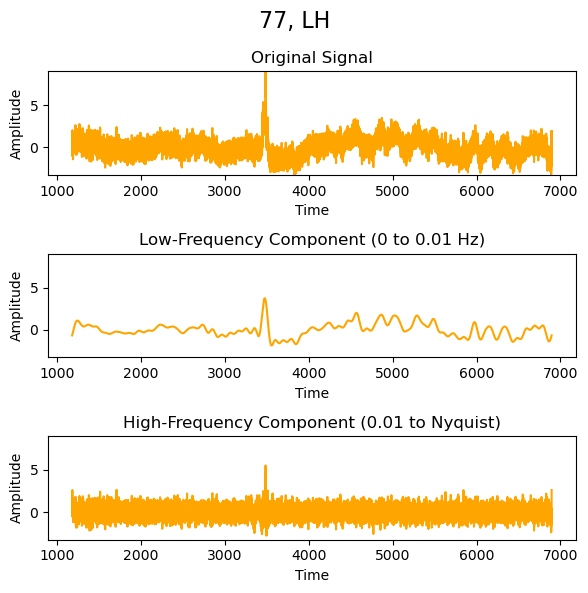

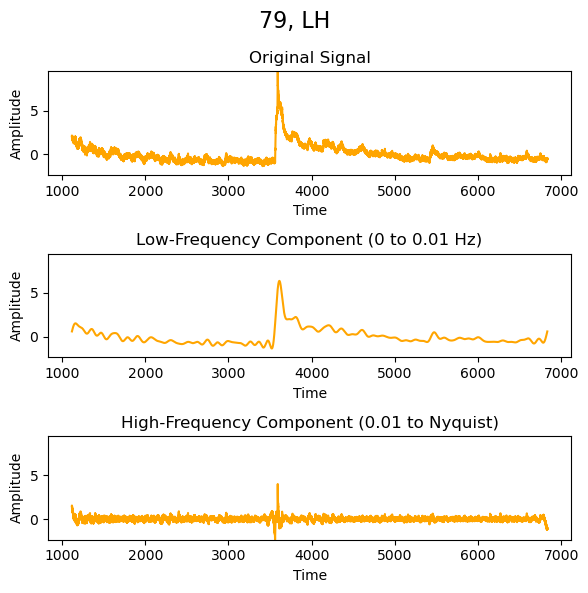

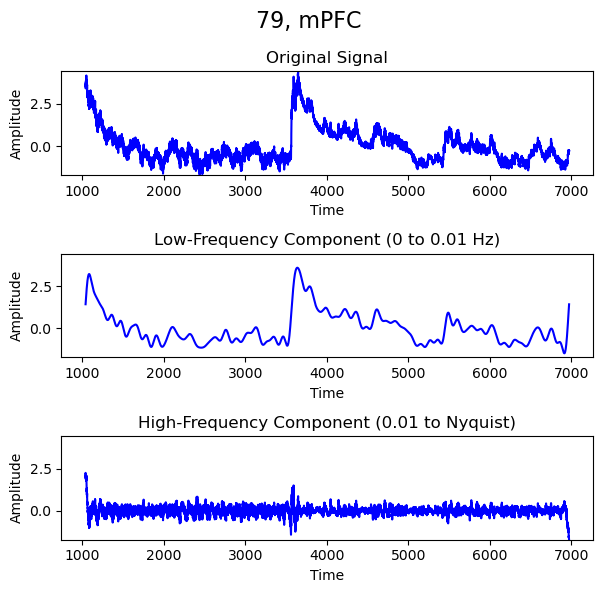

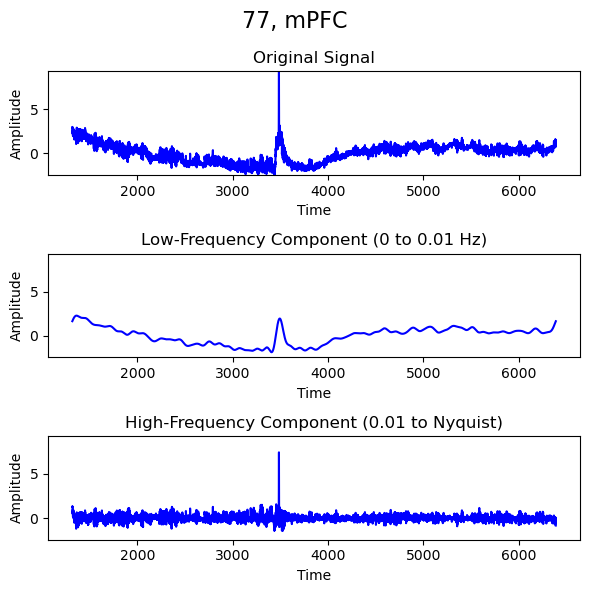

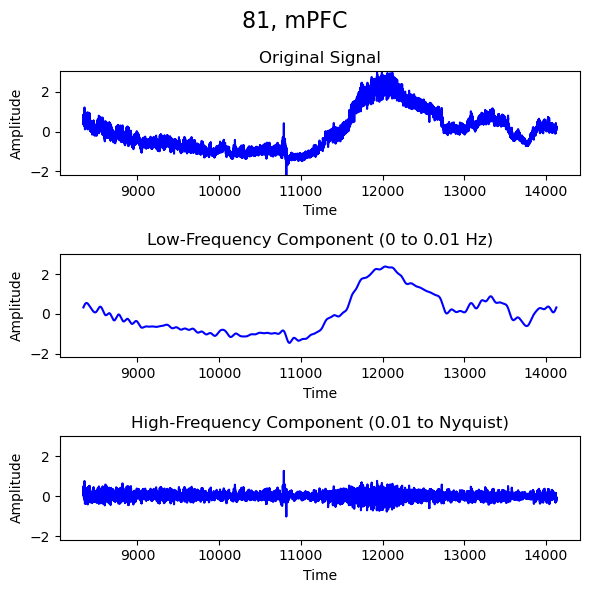

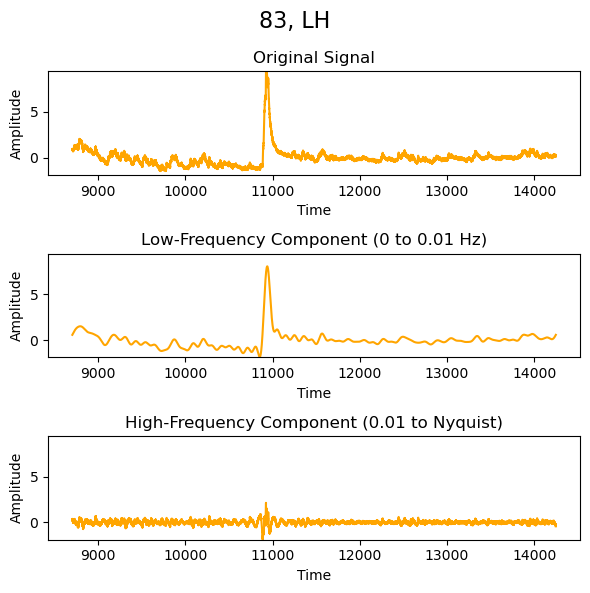

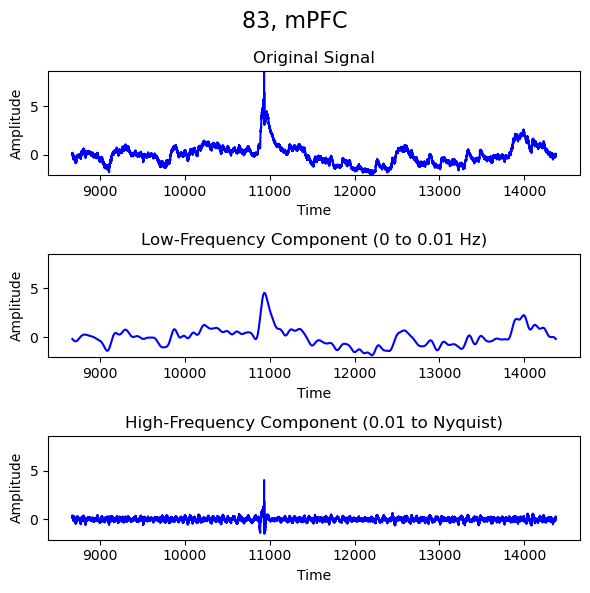

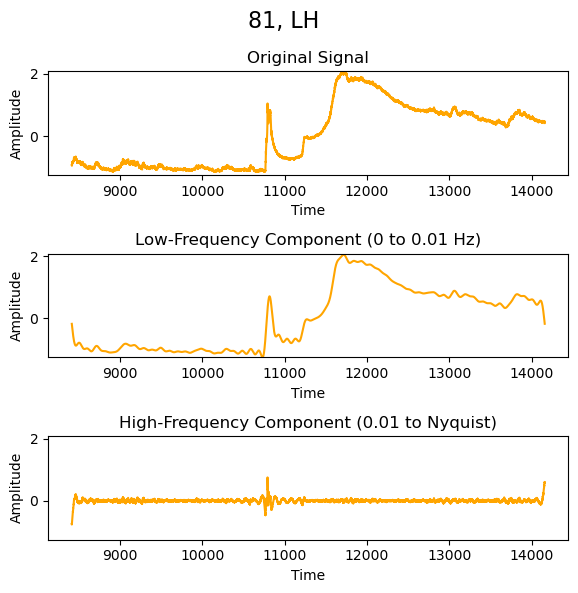

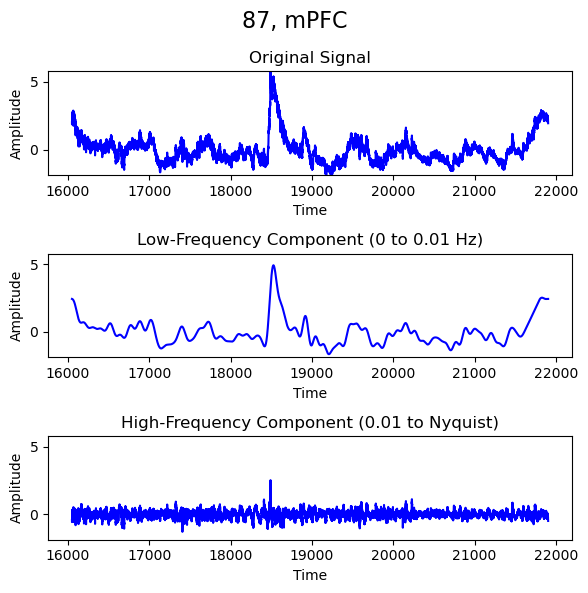

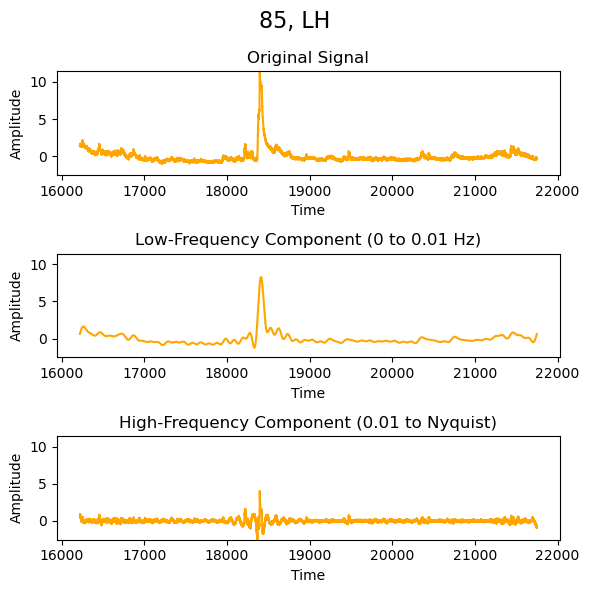

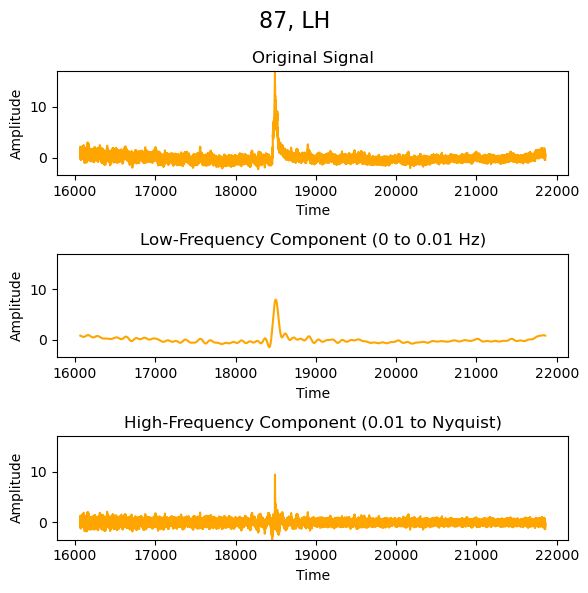

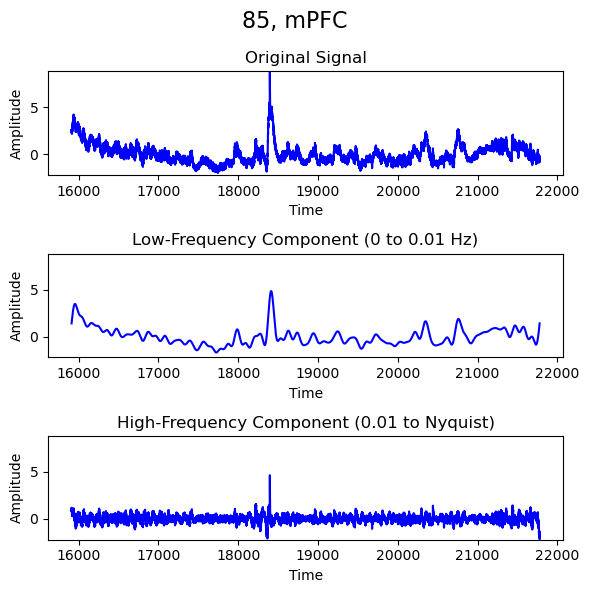

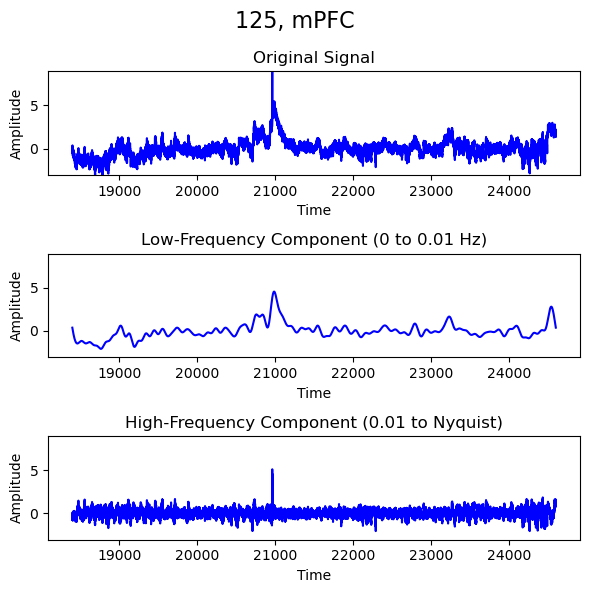

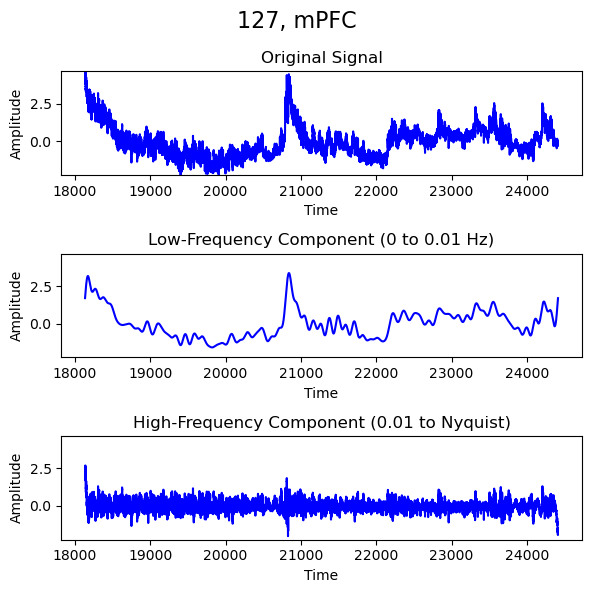

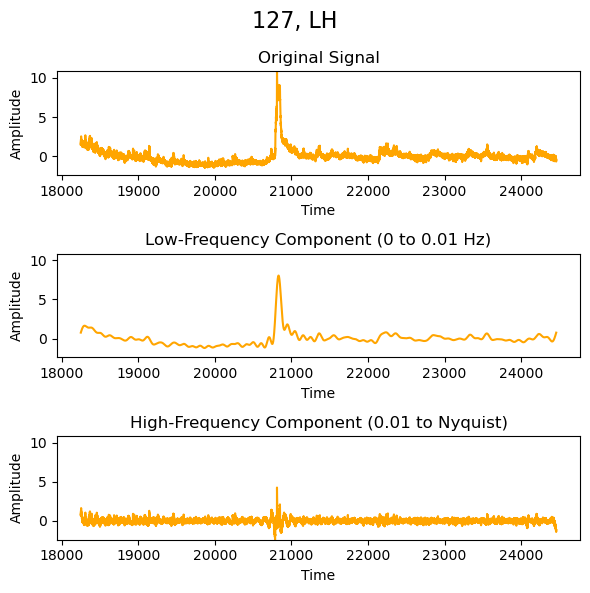

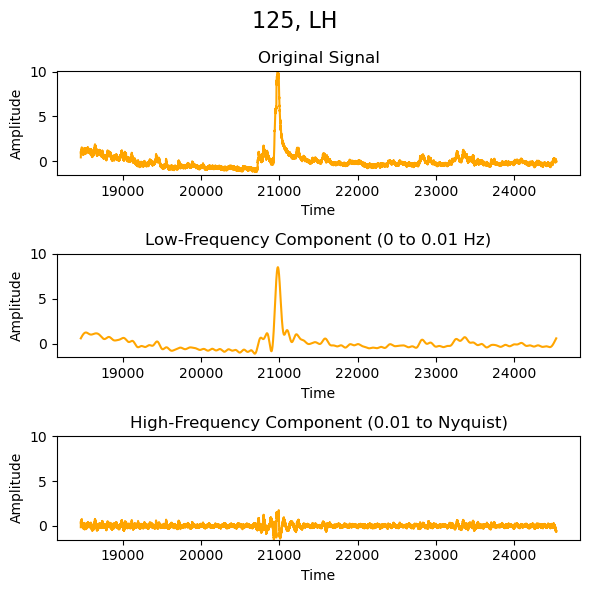

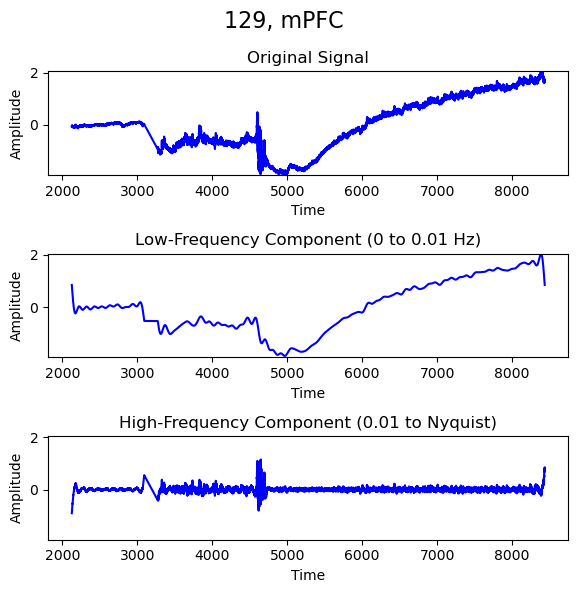

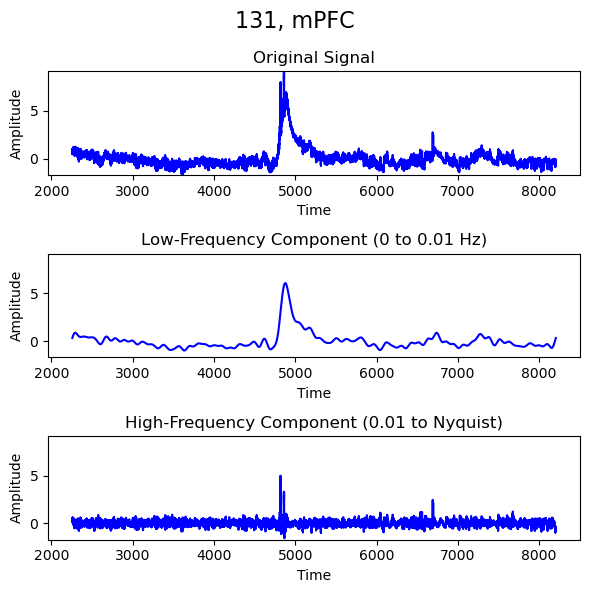

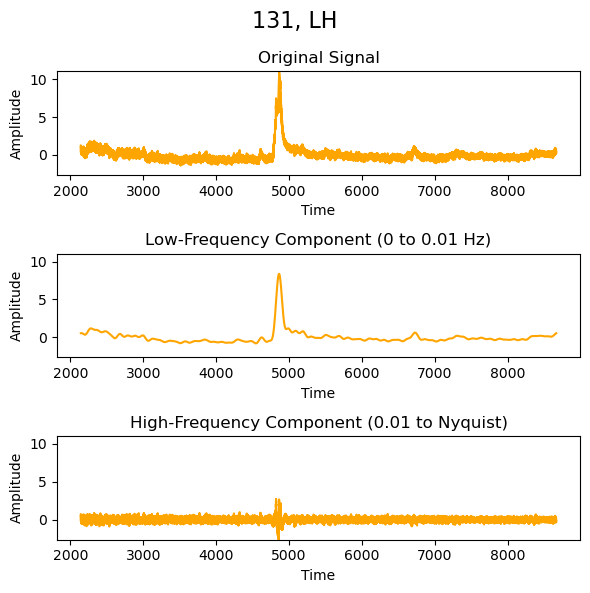

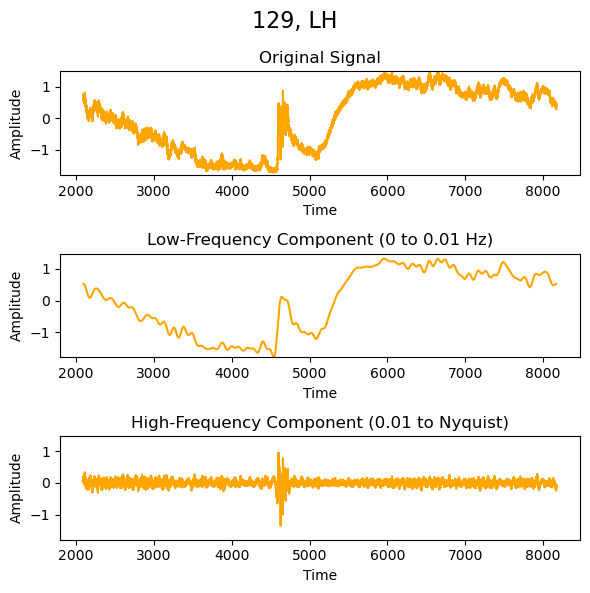

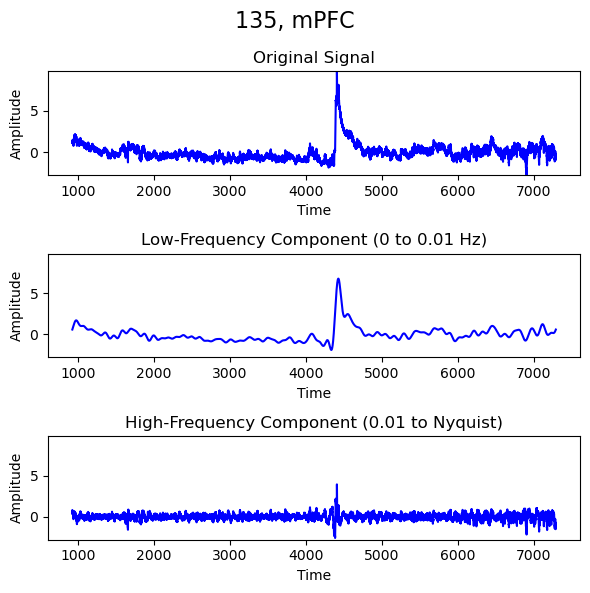

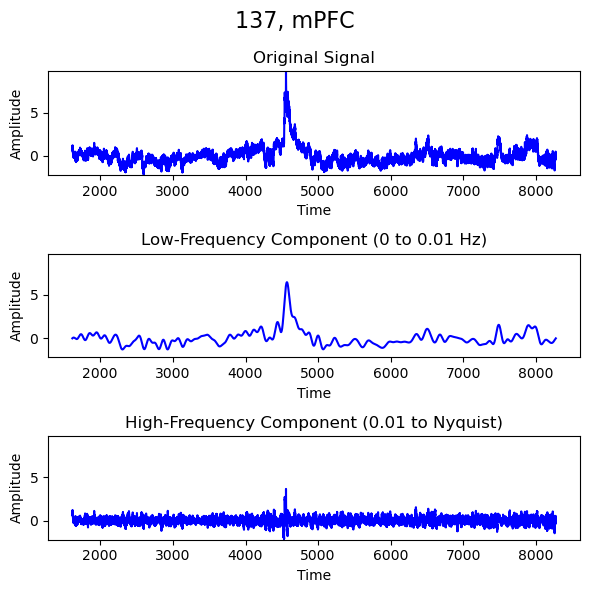

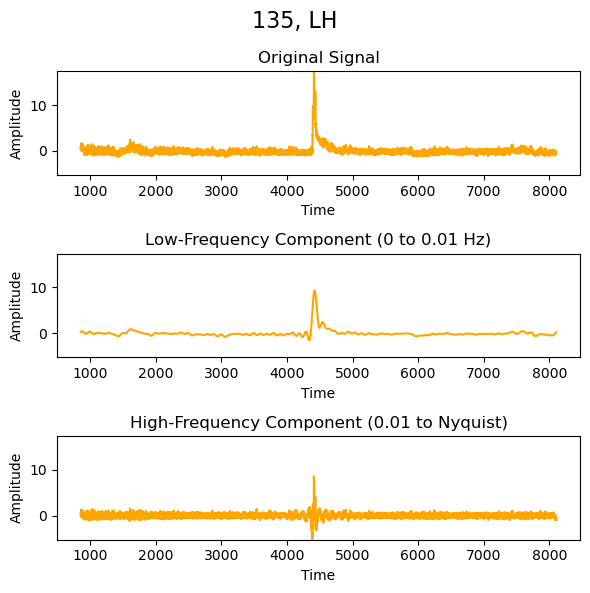

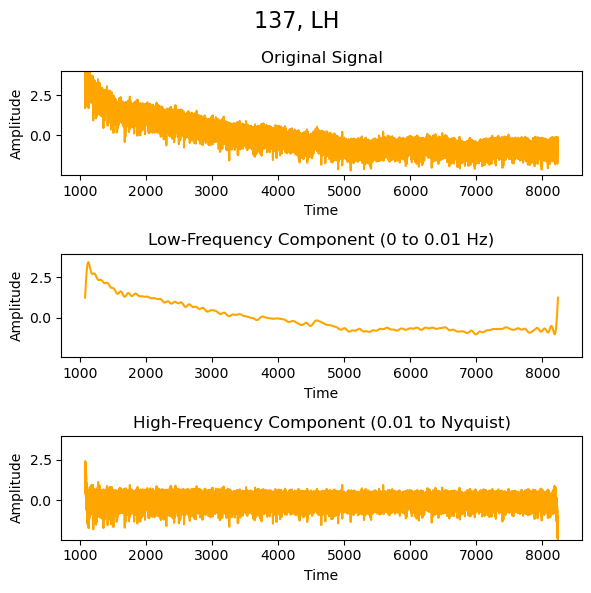

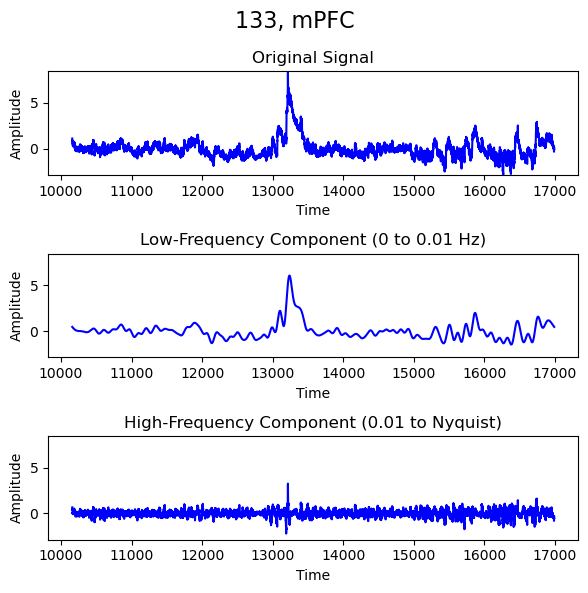

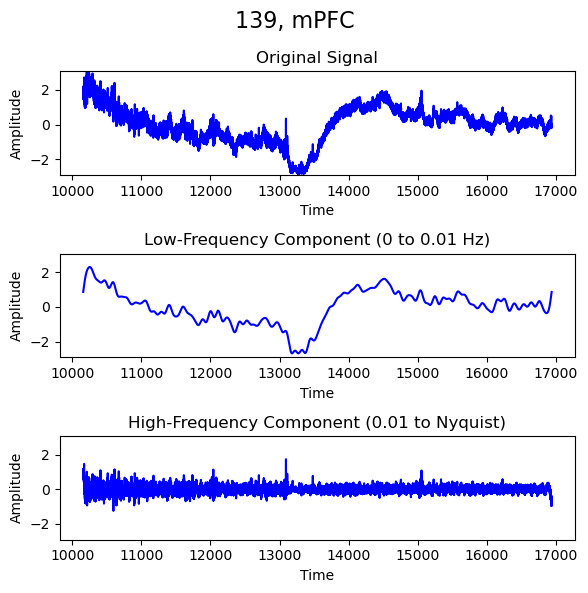

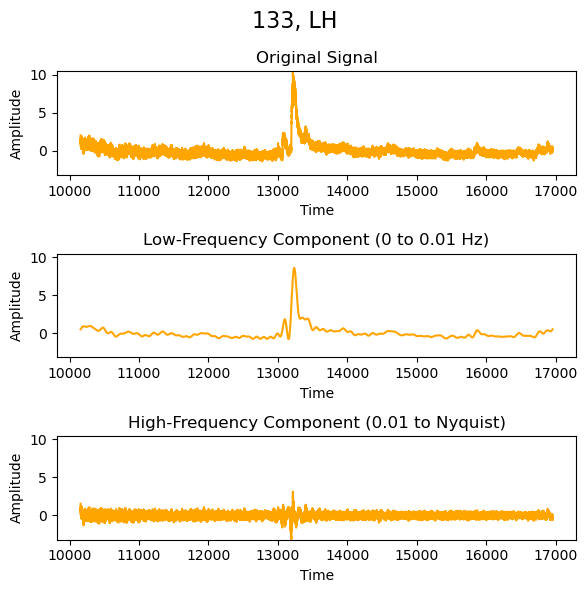

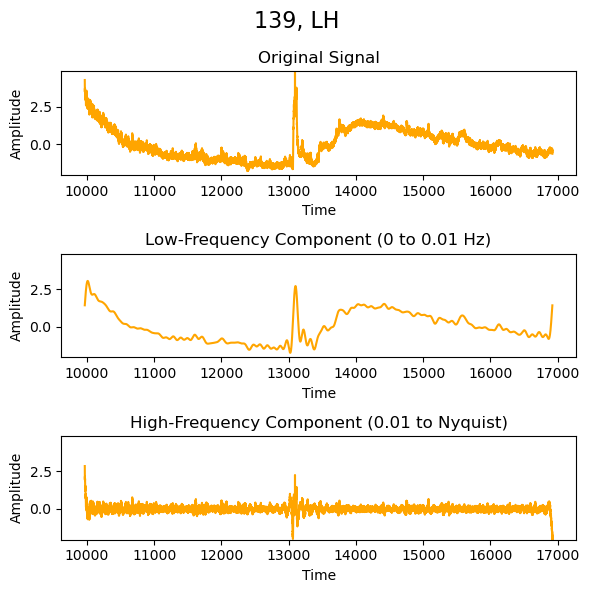

In [31]:
for (mouse_id, brain_region) in all_z_score_dfs.keys():
    # We discard these mice, for now, because the recordings are too short
    if mouse_id in ['635', '697']:
        continue

    t = all_z_score_dfs[(mouse_id, brain_region)]['timestamps']
    signal = all_z_score_dfs[(mouse_id, brain_region)]['data']
    #signal -= all_z_score_dfs['baseline'][(mouse_id, brain_region)]['data'].mean()

    # Process the signal for frequency separation
    signal, frequencies, low_freq_component, high_freq_component = process_signal(signal, sampling_rate, middle_freq)

    # Plot the frequency-separated components
    plot_signal(t, signal, low_freq_component, high_freq_component, middle_freq, 
                suptitle=f'{mouse_id}, {brain_region}', brain_region=brain_region)

    # Compute the frequency density
    #positive_frequencies, positive_relative_density = compute_frequency_density(signal, sampling_rate)
    positive_frequencies, positive_relative_density = compute_frequency_amplitude(signal, sampling_rate)

    # Plot the frequency density histogram
    # plot_frequency_density(positive_frequencies, positive_relative_density, a, b, num_bins)

In [ ]:
# for segment_str, segment_dfs in all_segment_dfs.items():
#     for (mouse_id, brain_region) in segment_dfs.keys():
#         # We discard these mice, for now, because the recordings are too short
#         if mouse_id in ['635', '697']:
#             continue

#         t = segment_dfs[(mouse_id, brain_region)]['timestamps']
#         signal = segment_dfs[(mouse_id, brain_region)]['data']
#         signal -= all_segment_dfs['baseline'][(mouse_id, brain_region)]['data'].mean()

#         # Process the signal for frequency separation
#         signal, frequencies, low_freq_component, high_freq_component = process_signal(signal, sampling_rate, middle_freq)

#         # Plot the frequency-separated components
#         plot_signal(t, signal, low_freq_component, high_freq_component, middle_freq, 
#                     suptitle=f'{mouse_id}, {brain_region}, {segment_str}', brain_region=brain_region)

#         # Compute the frequency density
#         #positive_frequencies, positive_relative_density = compute_frequency_density(signal, sampling_rate)
#         positive_frequencies, positive_relative_density = compute_frequency_amplitude(signal, sampling_rate)

#         # Plot the frequency density histogram
#         # plot_frequency_density(positive_frequencies, positive_relative_density, a, b, num_bins)

In [32]:
# Define the lists for WT and KO mouse IDs
wt_ids = [109, 944, 940, 873, 699, 106, 935, 728, 697]
ko_ids = [110, 946, 877, 875, 635, 107, 105, 938, 871, 870]
genotype_ids = {'wt': wt_ids, 'ko': ko_ids}

def generate_geno_brain_reg_segments(brain_reg, genotype):
    # Initialize dictionaries to store frequencies and densities
    all_frequencies = {}
    all_densities = {}

    # Iterate over each segment (baseline, nicotine, antagonist)
    for segment_name, segment_dfs in all_segment_dfs.items():
        segment_freqs = []
        segment_densities = []

        for (mouse_id, brain_region) in segment_dfs.keys():
            if mouse_id in ['635', '697']:
                continue
            if int(mouse_id) not in genotype_ids[genotype]:
                continue
            if brain_region != brain_reg:
                continue

            signal = segment_dfs[(mouse_id, brain_region)]['data']
            signal -= all_segment_dfs['baseline'][(mouse_id, brain_region)]['data'].mean()
            positive_frequencies, positive_relative_density = compute_frequency_density(signal, 15)
            # positive_frequencies, positive_relative_density = compute_frequency_amplitude(signal, 15)

            segment_freqs.append(positive_frequencies)
            segment_densities.append(positive_relative_density)

        # Store the results for the current segment
        all_frequencies[segment_name] = segment_freqs
        all_densities[segment_name] = segment_densities
    return all_frequencies, all_densities

In [33]:
all_segment_dfs.keys()

dict_keys(['baseline', 'nicotine', 'antagonist'])

In [21]:
for k in all_segment_dfs['baseline'].keys():
    for segment in ['baseline', 'nicotine', 'antagonist']:
        curr_segment = all_segment_dfs[segment][k]
        curr_ts = curr_segment['timestamps'].tolist()
        print(k, segment, (curr_ts[-1] - curr_ts[0])/60)
    print('')

('728', 'vs') baseline 14.998260266666659
('728', 'vs') nicotine 29.999853333333316
('728', 'vs') antagonist 29.998746133333363

('728', 'dls') baseline 14.998260266666659
('728', 'dls') nicotine 29.999853333333316
('728', 'dls') antagonist 29.998746133333363

('697', 'dls') baseline 14.999379199999991
('697', 'dls') nicotine 29.99877333333334
('697', 'dls') antagonist 20.839104533333316

('635', 'vs') baseline 14.999378133333327
('635', 'vs') nicotine 29.998774400000002
('635', 'vs') antagonist 20.146917333333324

('697', 'vs') baseline 14.999379199999991
('697', 'vs') nicotine 29.99877333333334
('697', 'vs') antagonist 21.106870399999995

('635', 'dls') baseline 14.999378133333327
('635', 'dls') nicotine 29.998774400000002
('635', 'dls') antagonist 20.34801973333333

('871', 'dls') baseline 14.99825919999994
('871', 'dls') nicotine 29.999848533333353
('871', 'dls') antagonist 29.999840533333373

('107', 'vs') baseline 14.999382399999982
('107', 'vs') nicotine 29.999860266666655
('107

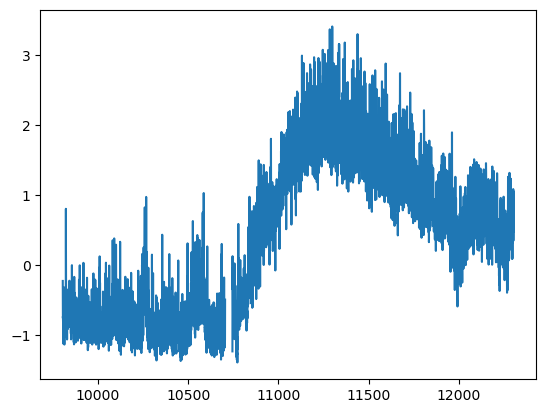

In [22]:
example = pd.concat(all_segment_dfs[segment][('697', 'vs')] 
          for segment in ['baseline', 'nicotine', 'antagonist'])


new_index = pd.RangeIndex(start=example.index.min(), stop=example.index.max() + 1)

# Reindex the DataFrame, filling new rows with NaN
df_filled = example.reindex(new_index)

plt.plot(df_filled.iloc[:2500*15]['timestamps'], df_filled.iloc[:2500*15]['data'])

<Figure size 1200x600 with 0 Axes>

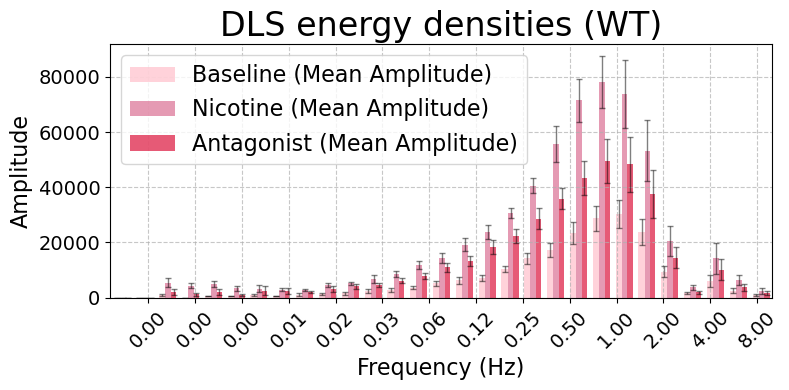

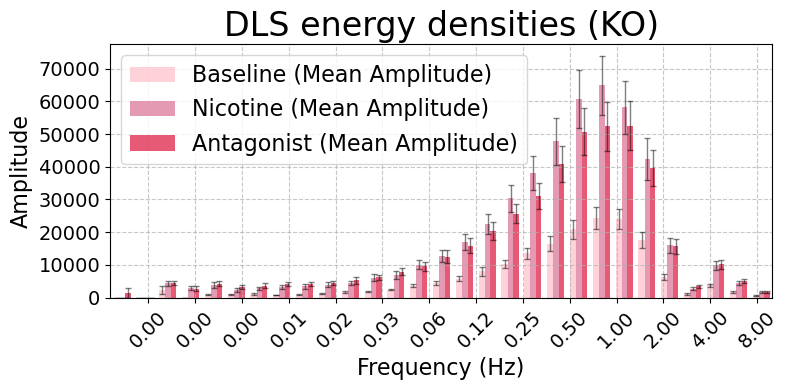

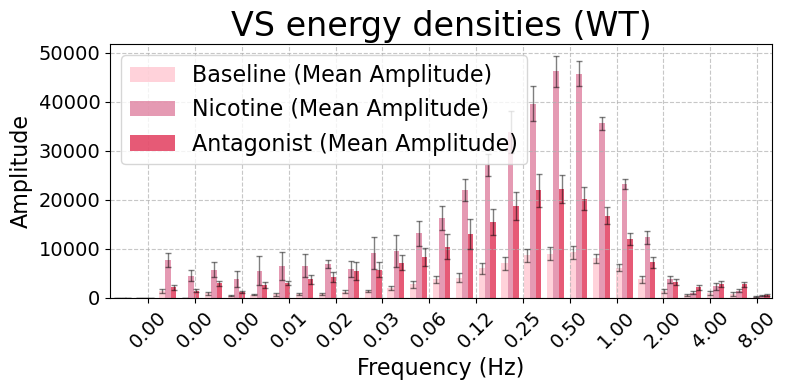

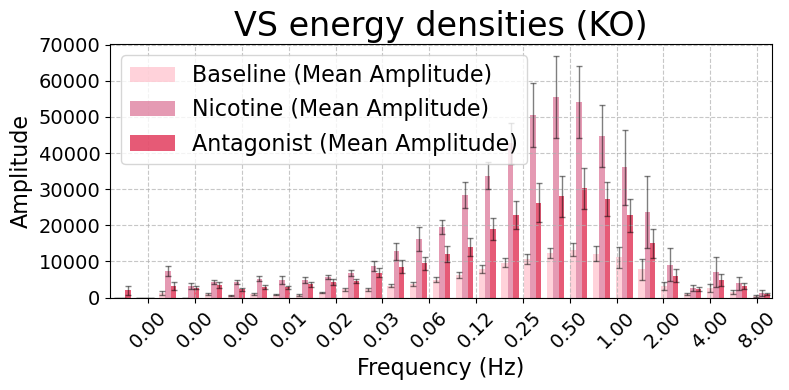

In [34]:
################
# Plotting
plt.figure(figsize=(12, 6))

color_lists = [['pink', 'palevioletred', 'crimson'], ['pink', 'palevioletred', 'crimson']]
for color_list, brain_region in zip(color_lists, ['dls', 'vs']):
    for genotype in ['wt', 'ko']:
        all_frequencies, all_densities = generate_geno_brain_reg_segments(brain_region, genotype)
        # plot_combined_frequency_density(
        plot_combined_frequency_amplitude(
            [all_frequencies['baseline'], all_frequencies['nicotine'], all_frequencies['antagonist']],
            [all_densities['baseline'], all_densities['nicotine'], all_densities['antagonist']],
            a, b, num_bins,
            labels=['Baseline', 'Nicotine', 'Antagonist'],
            colors=['pink', 'palevioletred', 'crimson'],
            title=f'{brain_region.upper()} energy densities ({genotype.upper()})'
        )
        plt.show()

<Figure size 1200x600 with 0 Axes>

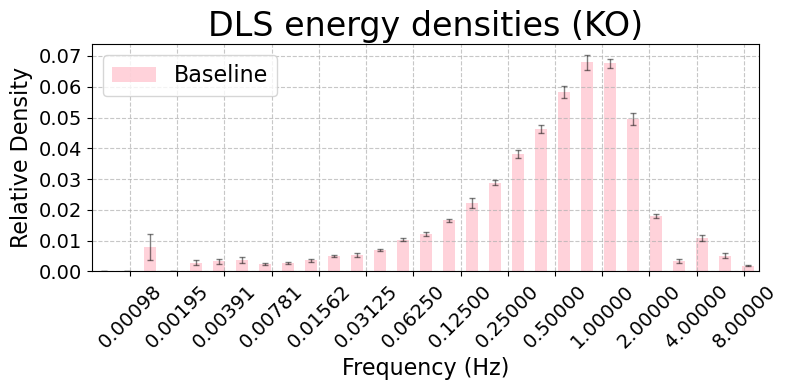

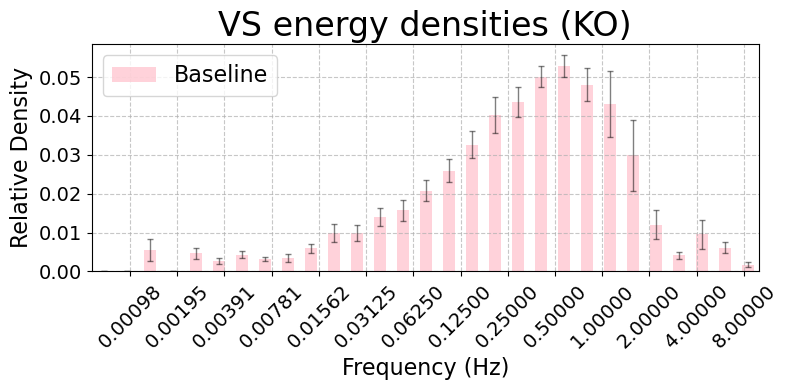

In [24]:
####sam trying stuff

################
# Plotting
plt.figure(figsize=(12, 6))

for brain_region in ['dls', 'vs']:
    all_frequencies, all_densities = generate_geno_brain_reg_segments(brain_region, genotype)
    plot_combined_frequency_density(
        [all_frequencies['baseline']],
        [all_densities['baseline']],
        a, b, num_bins,
        labels=['Baseline'],
        colors=['pink', 'palevioletred', 'crimson'],
        title=f'{brain_region.upper()} energy densities ({genotype.upper()})'
    )
    plt.show()

<Figure size 1200x600 with 0 Axes>

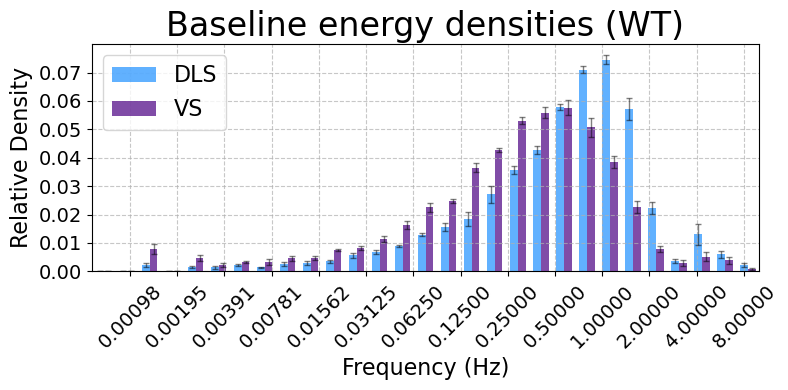

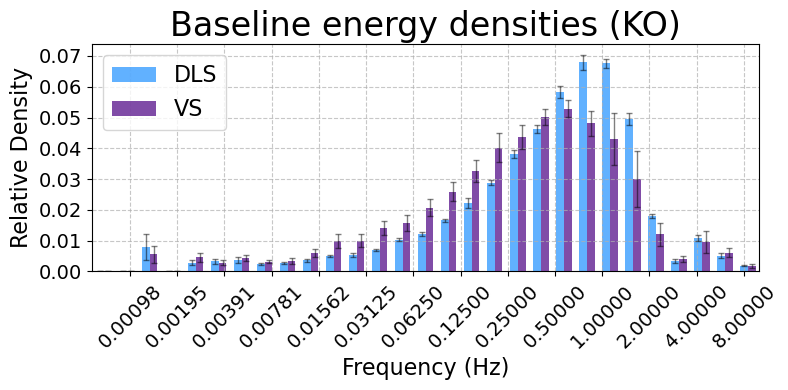

In [25]:
#####from chatgpt

# Initialize the figure size
plt.figure(figsize=(12, 6))

# Loop through the genotypes, and group both brain regions in a single plot
for genotype in ['wt', 'ko']:
    # Create lists to hold the data for both brain regions
    combined_frequencies = []
    combined_densities = []
    
    # Loop through the brain regions and collect baseline data
    for brain_region in ['dls', 'vs']:
        all_frequencies, all_densities = generate_geno_brain_reg_segments(brain_region, genotype)
        combined_frequencies.append(all_frequencies['baseline'])
        combined_densities.append(all_densities['baseline'])

    # Plot the combined frequency and density for both brain regions
    plot_combined_frequency_density(
        combined_frequencies,  # Only baseline frequencies for both brain regions
        combined_densities,    # Only baseline densities for both brain regions
        a, b, num_bins,
        labels=['DLS', 'VS'],  # Labels for each brain region
        colors=['dodgerblue', 'indigo'],        # Different colors for different brain regions
        title=f'Baseline energy densities ({genotype.upper()})'  # Title with genotype
    )
    
    # Show the plot
    plt.show()


<Figure size 1200x600 with 0 Axes>

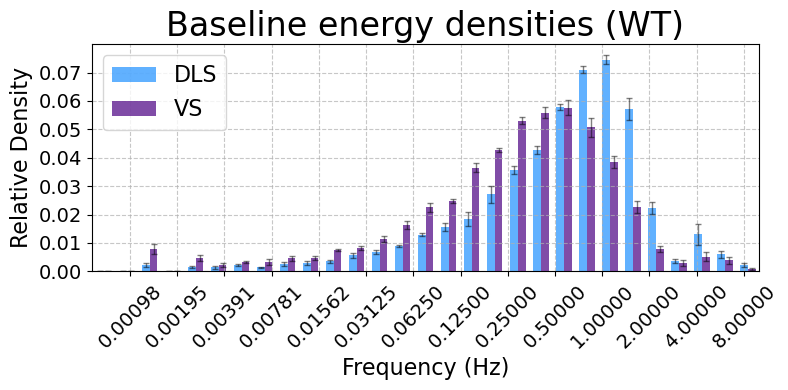

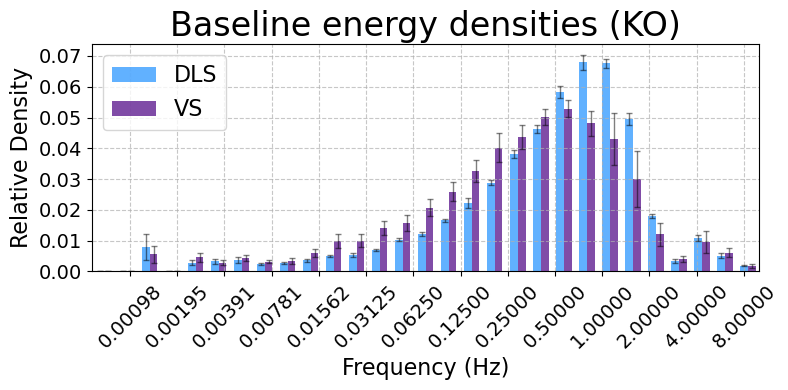

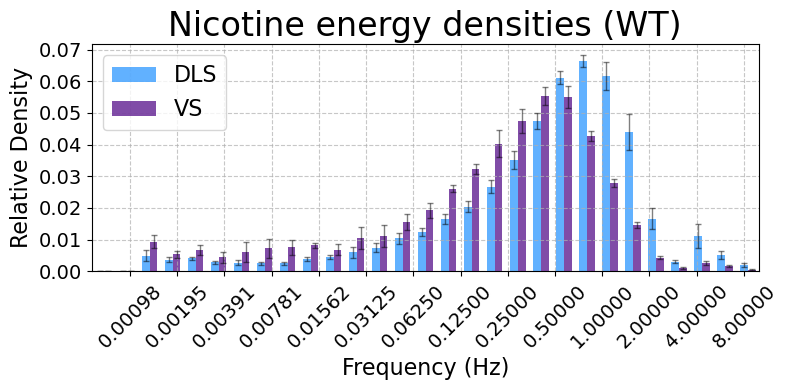

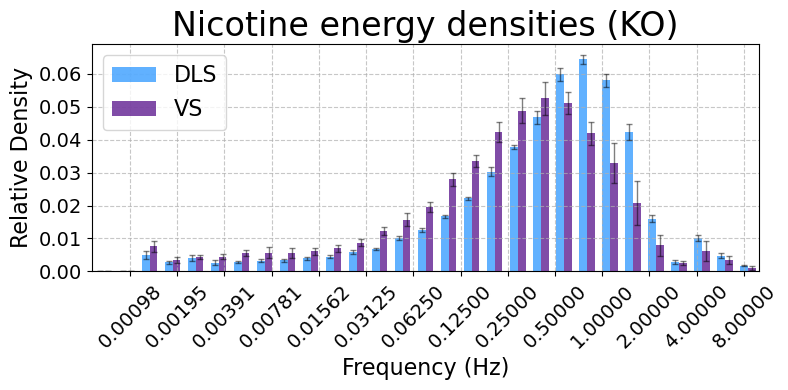

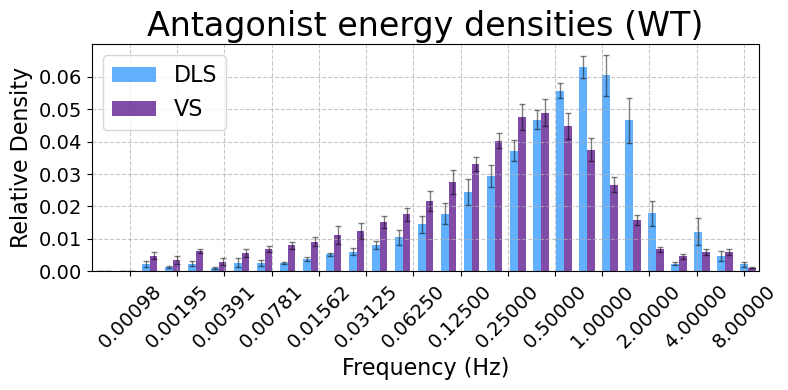

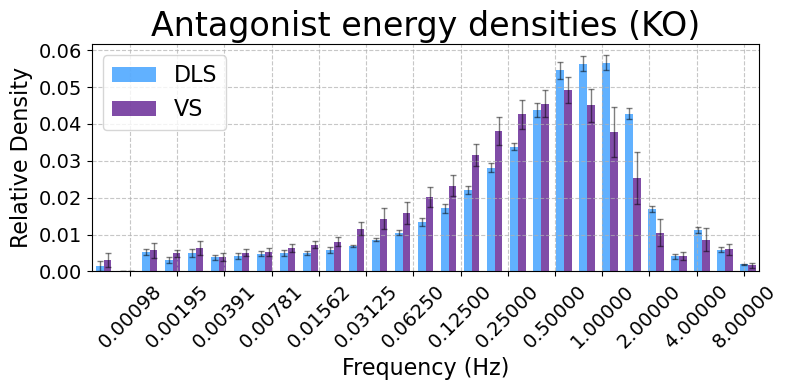

In [26]:
### also from chatgpt

# Initialize the figure size
plt.figure(figsize=(12, 6))

# Loop through the signals first
for signal in ['baseline', 'nicotine', 'antagonist']:
    # Loop through the genotypes and group both brain regions in a single plot
    for genotype in ['wt', 'ko']:
        # Create lists to hold the data for both brain regions
        combined_frequencies = []
        combined_densities = []
        
        # Loop through the brain regions and collect data for the current signal
        for brain_region in ['dls', 'vs']:
            all_frequencies, all_densities = generate_geno_brain_reg_segments(brain_region, genotype)
            combined_frequencies.append(all_frequencies[signal])
            combined_densities.append(all_densities[signal])

        # Plot the combined frequency and density for both brain regions
        plot_combined_frequency_density(
            combined_frequencies,  # Frequencies for the current signal across both brain regions
            combined_densities,    # Densities for the current signal across both brain regions
            a, b, num_bins,
            labels=['DLS', 'VS'],  # Labels for each brain region
            colors=['dodgerblue', 'indigo'],  # Different colors for different brain regions
            title=f'{signal.capitalize()} energy densities ({genotype.upper()})'  # Title with signal and genotype
        )
        
        # Show the plot
        plt.show()



<Figure size 1200x600 with 0 Axes>

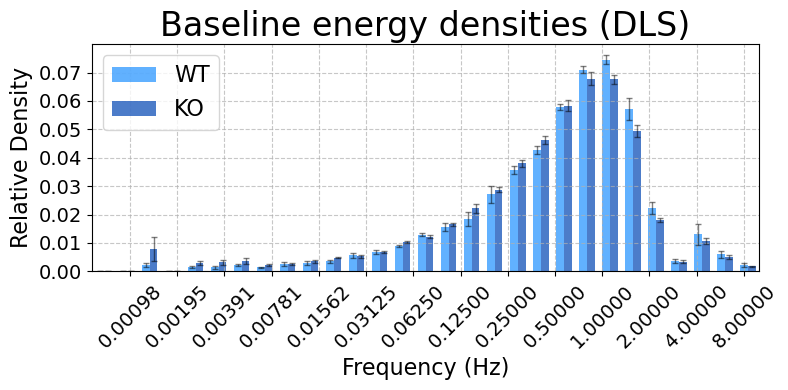

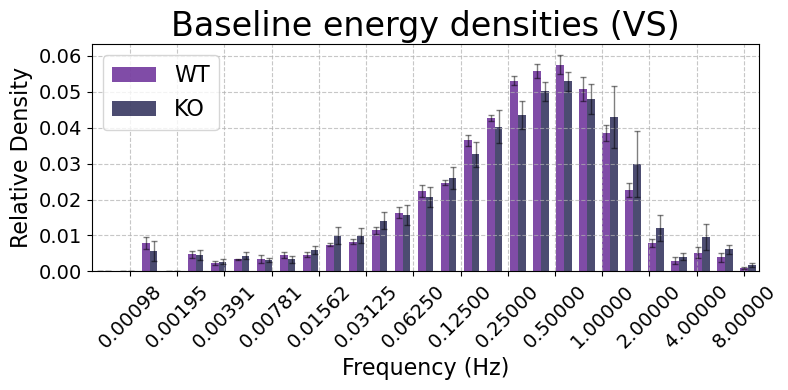

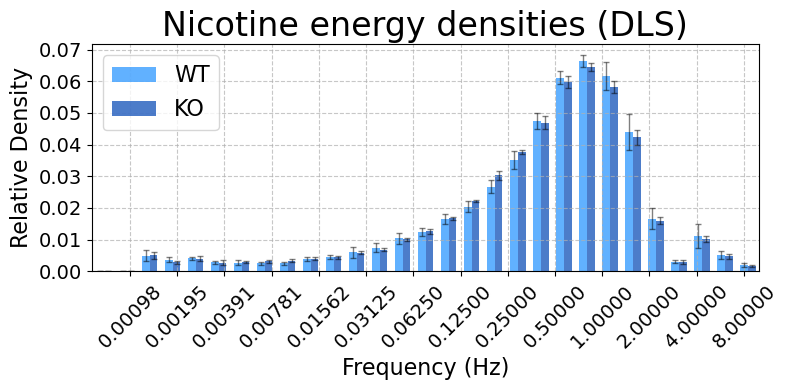

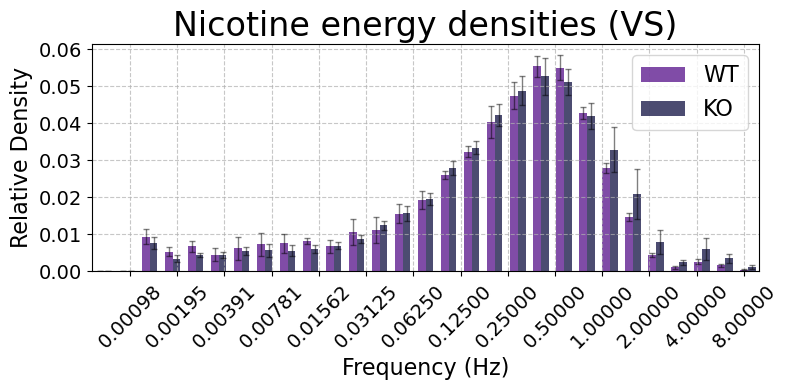

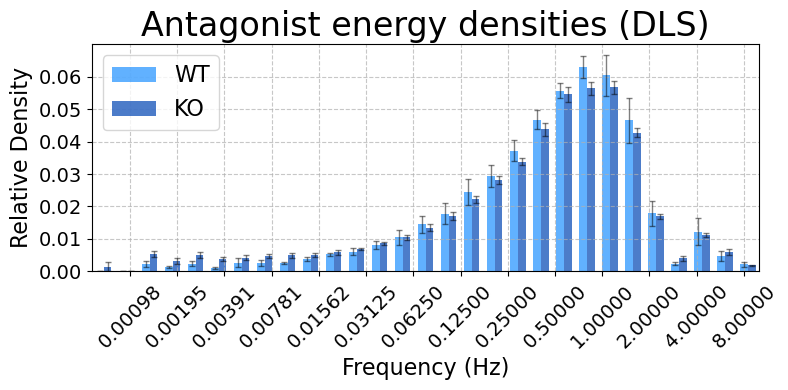

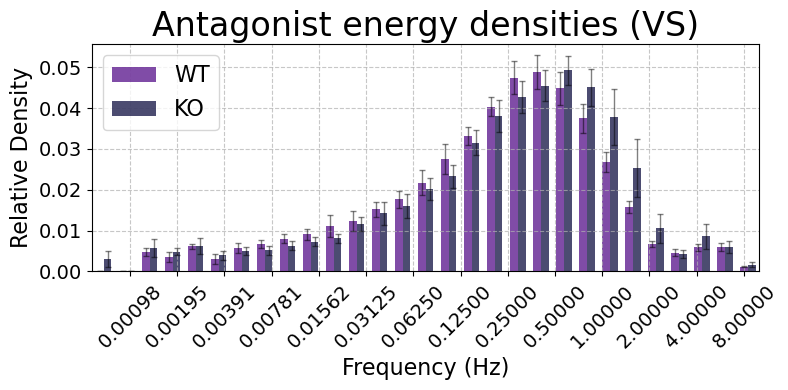

In [27]:
import matplotlib.colors as mcolors

def darken_color(color, amount=0.3):
    """Darkens a given RGB color by the specified amount."""
    c = mcolors.to_rgb(color)
    return tuple(max(0, x - amount) for x in c)

# Initialize the figure size
plt.figure(figsize=(12, 6))

# Loop through the signals first
for signal in ['baseline', 'nicotine', 'antagonist']:
    # Loop through the brain regions and group both genotypes in a single plot
    for brain_region in ['dls', 'vs']:
        # Determine the base color based on the brain region
        if brain_region == 'dls':
            color_wt = mcolors.to_rgb('dodgerblue')  # WT color
            color_ko = darken_color('dodgerblue', 0.3)  # Darker KO color
        else:  # 'vs'
            color_wt = mcolors.to_rgb('indigo')  # WT color
            color_ko = darken_color('indigo', 0.3)  # Darker KO color
        
        # Create lists to hold the data for both genotypes
        combined_frequencies = []
        combined_densities = []

        # Loop through the genotypes and collect data for the current signal
        for genotype in ['wt', 'ko']:
            all_frequencies, all_densities = generate_geno_brain_reg_segments(brain_region, genotype)
            combined_frequencies.append(all_frequencies[signal])
            combined_densities.append(all_densities[signal])

        # Plot the combined frequency and density for both genotypes
        plot_combined_frequency_density(
            combined_frequencies,  # Frequencies for the current signal across both genotypes
            combined_densities,    # Densities for the current signal across both genotypes
            a, b, num_bins,
            labels=['WT', 'KO'],  # Labels for each genotype
            colors=[color_wt, color_ko],  # Colors for WT and KO (KO is darker)
            title=f'{signal.capitalize()} energy densities ({brain_region.upper()})'  # Title with signal and brain region
        )
        
        # Show the plot
        plt.show()



